In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

In [2]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [3]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.

In [4]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import LabelEncoder, label_binarize

def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_fold = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled_np = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled_np = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled_np, columns=X_val.columns)

        # Encode target labels
        label_encoder = LabelEncoder()
        y_train_enc = label_encoder.fit_transform(y_train)
        y_val_enc = label_encoder.transform(y_val)
        class_names = label_encoder.classes_

        # Convert to NumPy arrays
        X_train_np = X_train_scaled.values
        X_val_np = X_val_scaled.values

        # Define and train TabNet model
        model = TabNetClassifier(
            seed=random_state,
            verbose=0
        )

        model.fit(
            X_train=X_train_np, y_train=y_train_enc,
            eval_set=[(X_train_np, y_train_enc), (X_val_np, y_val_enc)],
            eval_name=['train', 'val'],
            eval_metric=['balanced_accuracy'],
            max_epochs=100,
            patience=10,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0
        )

        # Plot training history
        history = model.history.history
        val_acc = history.get('val_balanced_accuracy', None)
        train_acc = history.get('train_balanced_accuracy', None)
        epochs = list(range(1, len(val_acc) + 1)) if val_acc else []
        
        if val_acc and train_acc:
            plt.figure(figsize=(6, 4))
            plt.plot(epochs, train_acc, label='Train Balanced Accuracy', marker='o', color='green')
            plt.plot(epochs, val_acc, label='Val Balanced Accuracy', marker='o', color='blue')
            plt.title(f'Fold {fold} - Balanced Accuracy per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Balanced Accuracy')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

        # Evaluate
        y_pred_enc = model.predict(X_val_np)
        y_pred = label_encoder.inverse_transform(y_pred_enc)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # AUC
        y_proba = model.predict_proba(X_val_np)
        y_val_bin = label_binarize(y_val_enc, classes=np.arange(len(class_names)))
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold
            best_label_encoder = label_encoder

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, class_label in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {class_label}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.title(f'Fold {fold} ROC Curves')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature Importances
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances.head(10))

    return best_model, best_scaler, best_fold, all_metrics


In [5]:
pd.set_option('display.max_rows', None)


=== Training Phase 1 ===

Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_balanced_accuracy = 0.35958


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


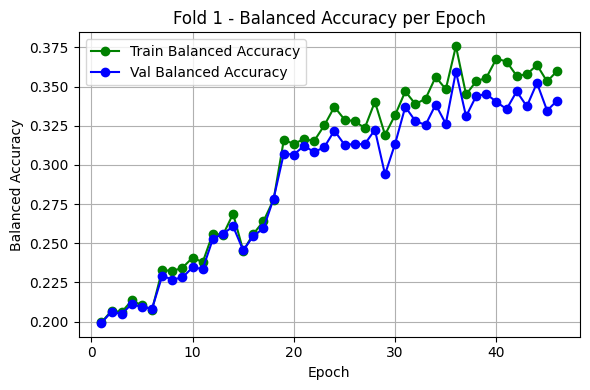

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.90      0.82      1785
           1       0.55      0.38      0.45       604
           2       0.47      0.28      0.35       258
           3       0.35      0.24      0.28        59
           4       0.00      0.00      0.00         9

    accuracy                           0.71      2715
   macro avg       0.43      0.36      0.38      2715
weighted avg       0.68      0.71      0.68      2715



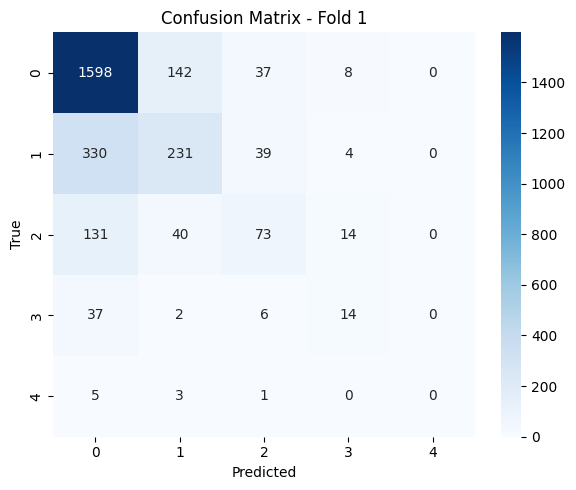

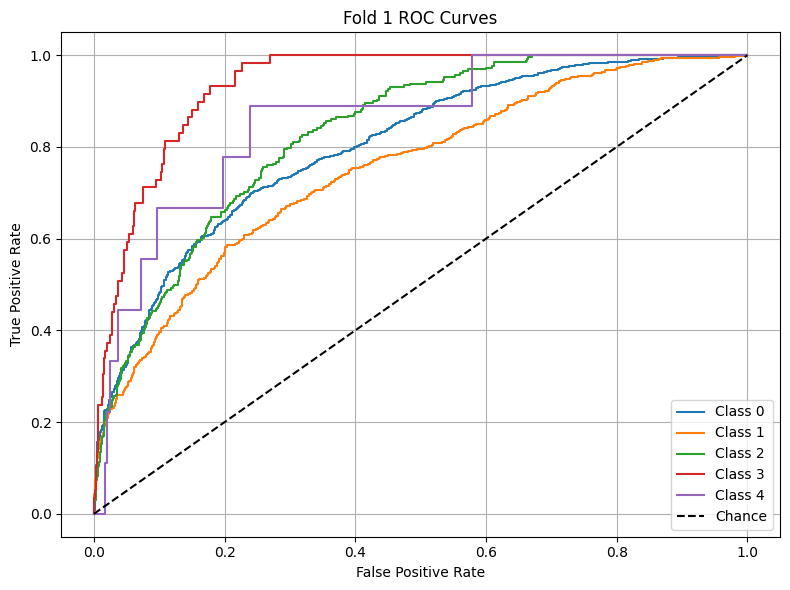


Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_balanced_accuracy = 0.32791


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


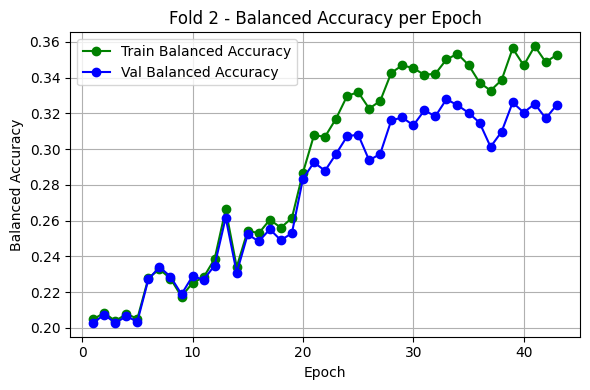

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.92      0.82      1786
           1       0.53      0.29      0.37       603
           2       0.50      0.28      0.36       258
           3       0.27      0.15      0.20        59
           4       0.00      0.00      0.00         8

    accuracy                           0.70      2714
   macro avg       0.41      0.33      0.35      2714
weighted avg       0.66      0.70      0.66      2714



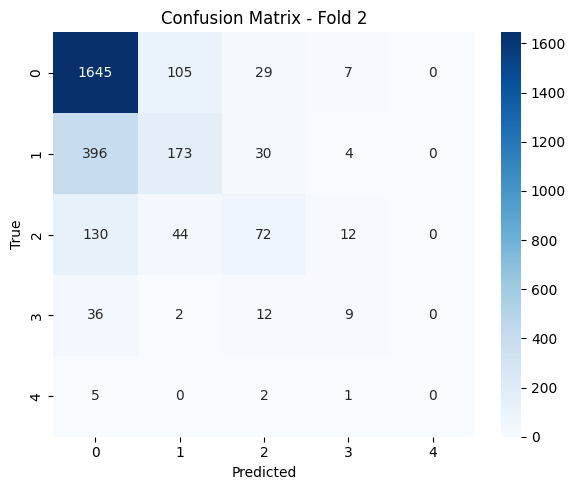

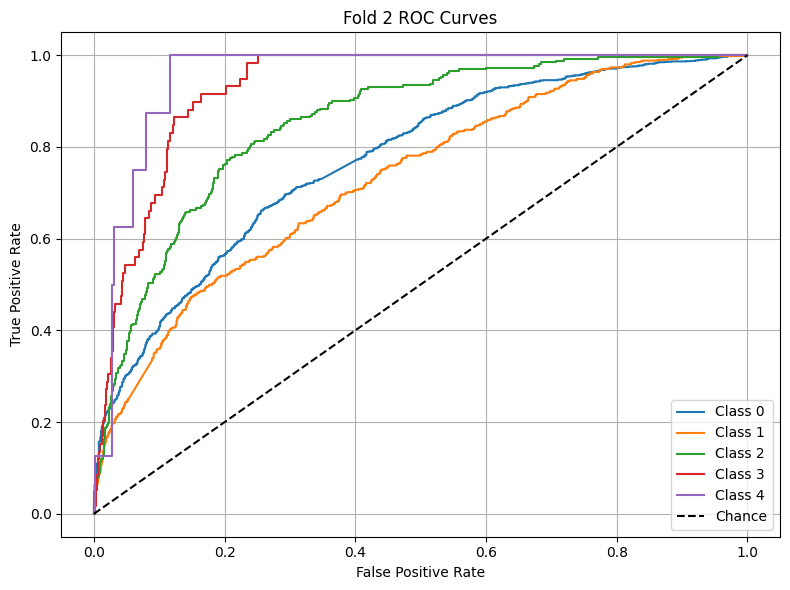


Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_balanced_accuracy = 0.3474


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


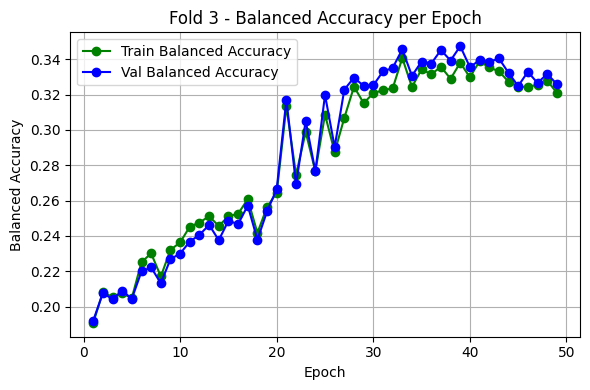

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.86      0.80      1786
           1       0.52      0.44      0.47       603
           2       0.43      0.19      0.26       258
           3       0.50      0.25      0.34        59
           4       0.00      0.00      0.00         8

    accuracy                           0.68      2714
   macro avg       0.44      0.35      0.37      2714
weighted avg       0.65      0.68      0.66      2714



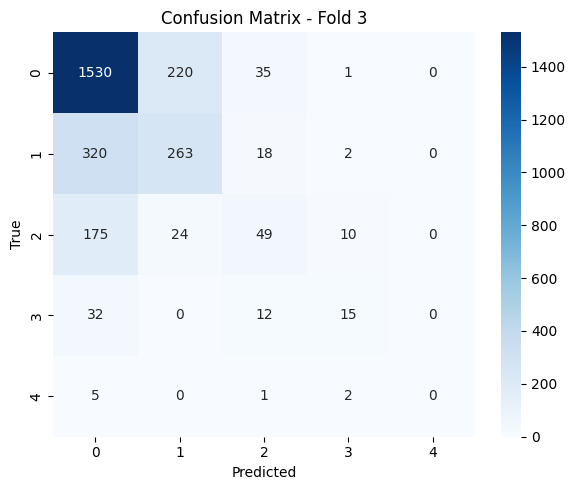

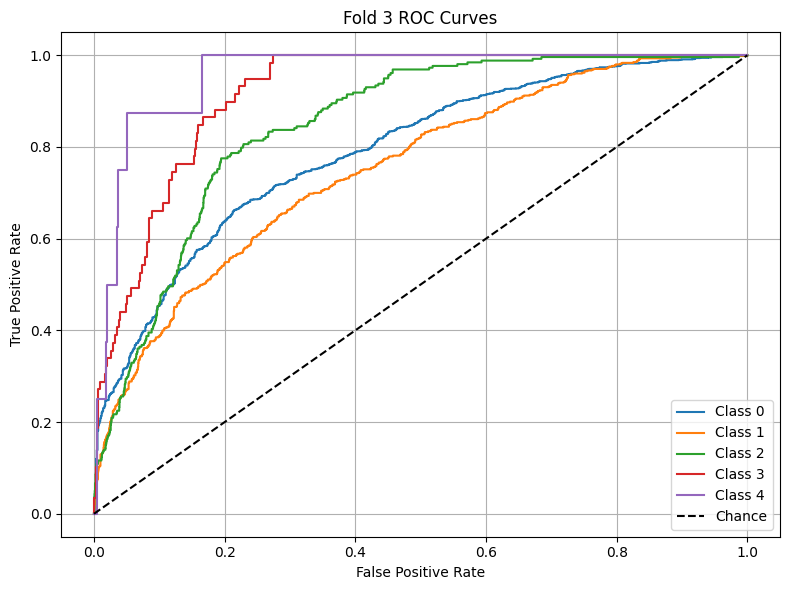


Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_balanced_accuracy = 0.3488


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


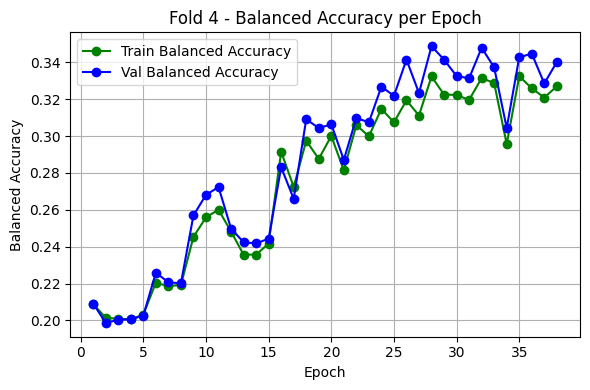

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.91      0.82      1785
           1       0.61      0.36      0.45       603
           2       0.51      0.24      0.32       258
           3       0.47      0.24      0.31        59
           4       0.00      0.00      0.00         9

    accuracy                           0.71      2714
   macro avg       0.46      0.35      0.38      2714
weighted avg       0.68      0.71      0.67      2714



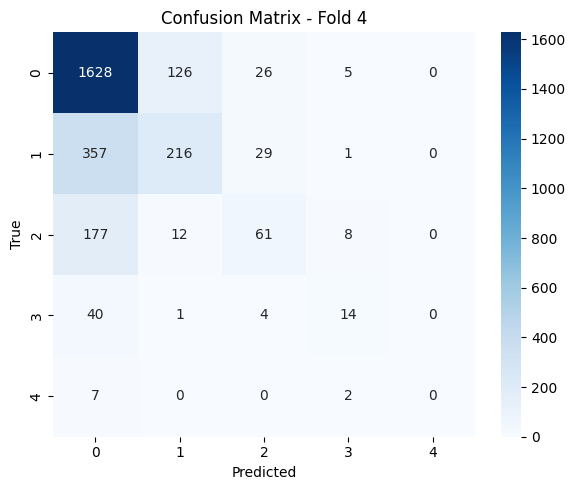

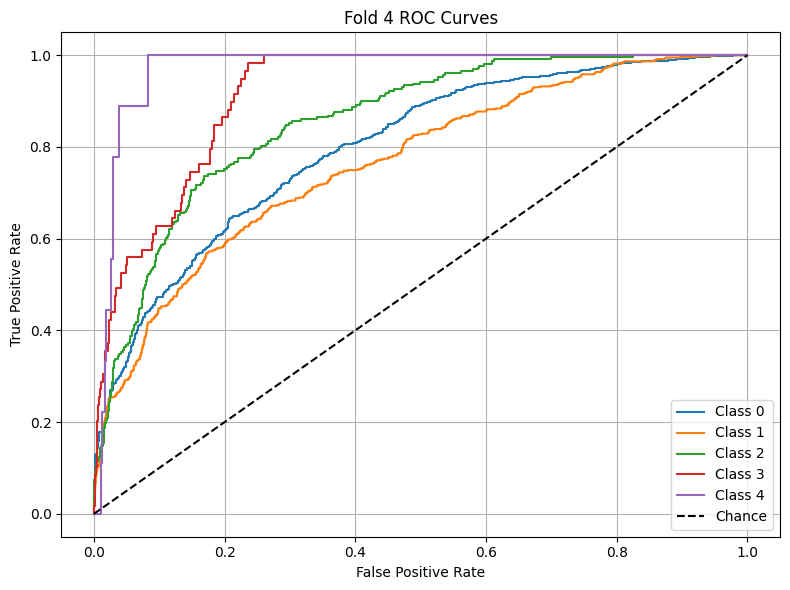


Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_balanced_accuracy = 0.35032


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


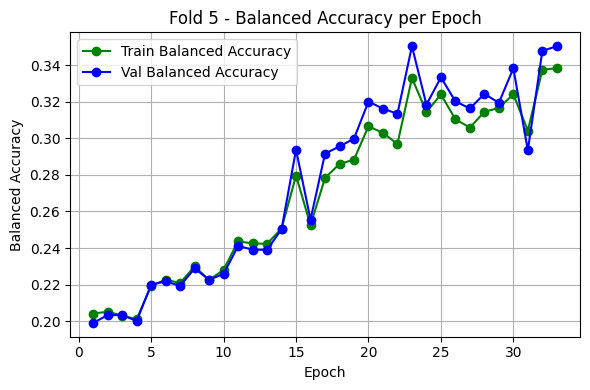

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.89      0.81      1785
           1       0.54      0.34      0.42       603
           2       0.43      0.19      0.27       258
           3       0.47      0.32      0.38        59
           4       0.00      0.00      0.00         9

    accuracy                           0.69      2714
   macro avg       0.44      0.35      0.37      2714
weighted avg       0.65      0.69      0.66      2714



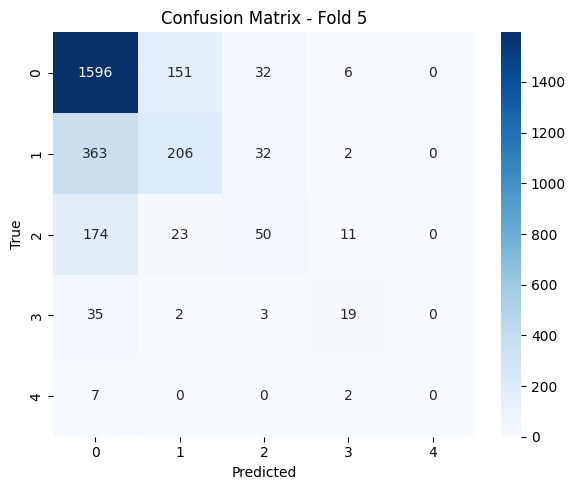

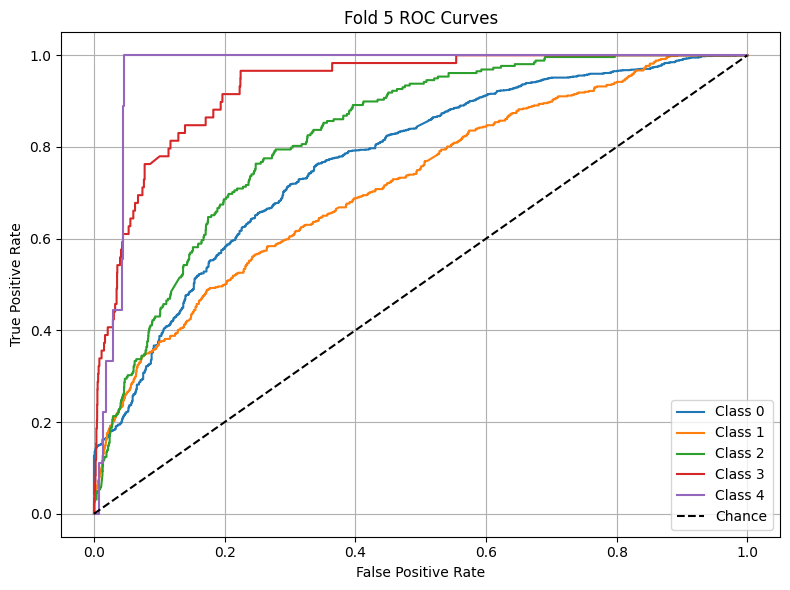


Average Accuracy: 0.6972
Average F1 Macro: 0.3723
Average AUC: 0.8484

Feature Importances:
assignment                    0.125083
combined_emb_13               0.120253
combined_emb_1                0.098549
combined_emb_3                0.078936
duration_days                 0.073188
combined_emb_11               0.070362
video_watched_percentage_1    0.038357
total_words_phase1            0.035523
exam                          0.035215
combined_emb_9                0.034175
dtype: float64

=== Training Phase 2 ===

Early stopping occurred at epoch 78 with best_epoch = 68 and best_val_balanced_accuracy = 0.37489


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


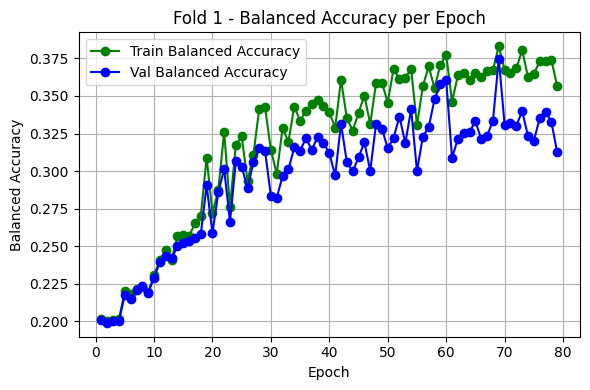


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.92      0.83      1489
           1       0.53      0.20      0.29       488
           2       0.43      0.42      0.42       220
           3       0.36      0.22      0.28        54
           4       1.00      0.11      0.20         9

    accuracy                           0.70      2260
   macro avg       0.61      0.37      0.40      2260
weighted avg       0.66      0.70      0.66      2260



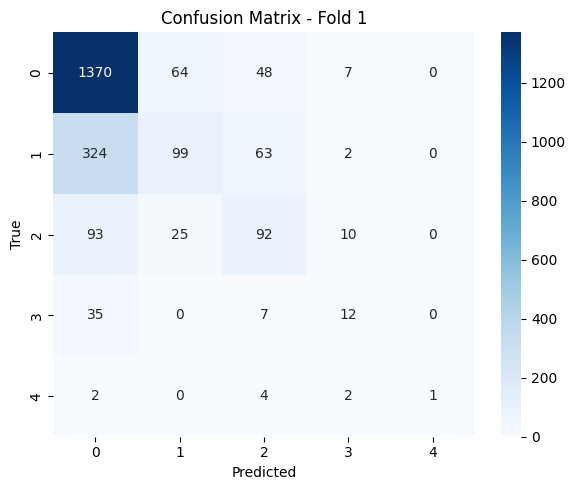

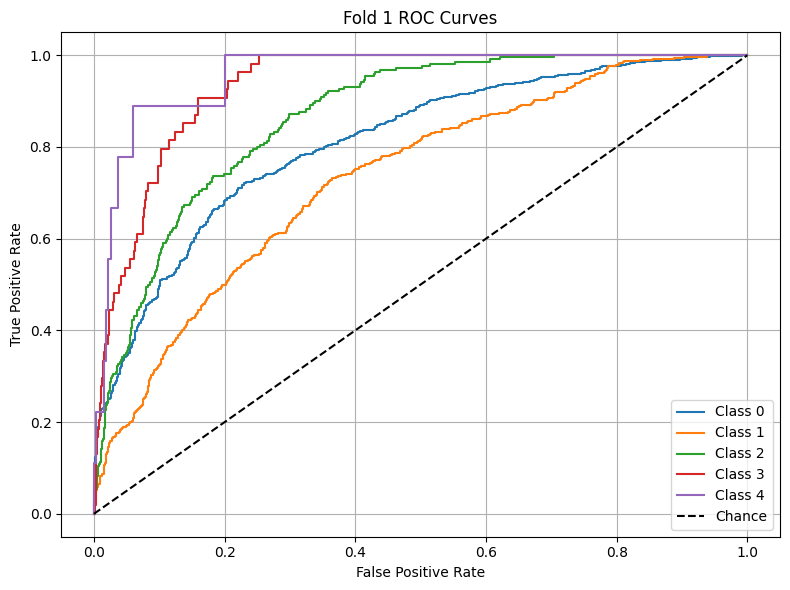


Early stopping occurred at epoch 60 with best_epoch = 50 and best_val_balanced_accuracy = 0.32752


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


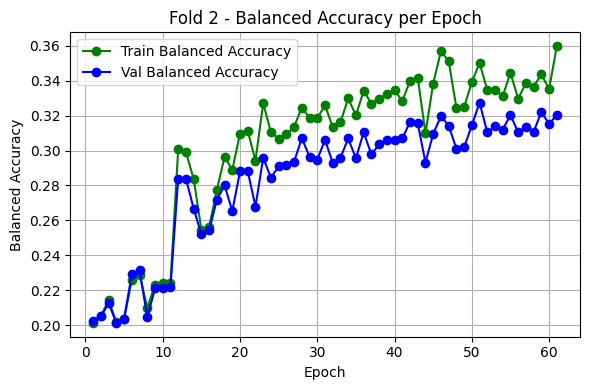

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.88      0.80      1489
           1       0.48      0.35      0.41       489
           2       0.50      0.23      0.31       219
           3       0.25      0.18      0.21        55
           4       0.00      0.00      0.00         8

    accuracy                           0.68      2260
   macro avg       0.39      0.33      0.35      2260
weighted avg       0.65      0.68      0.65      2260



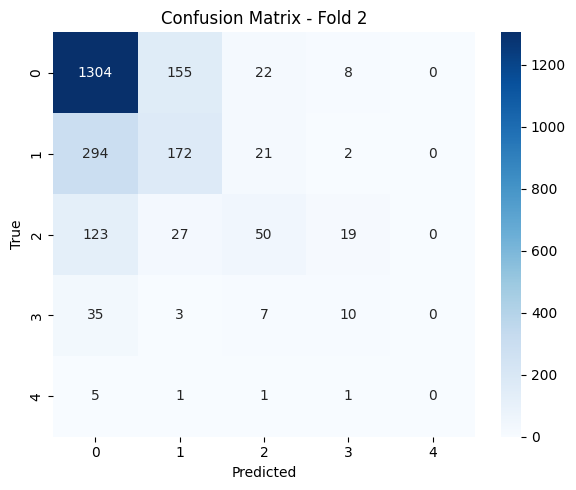

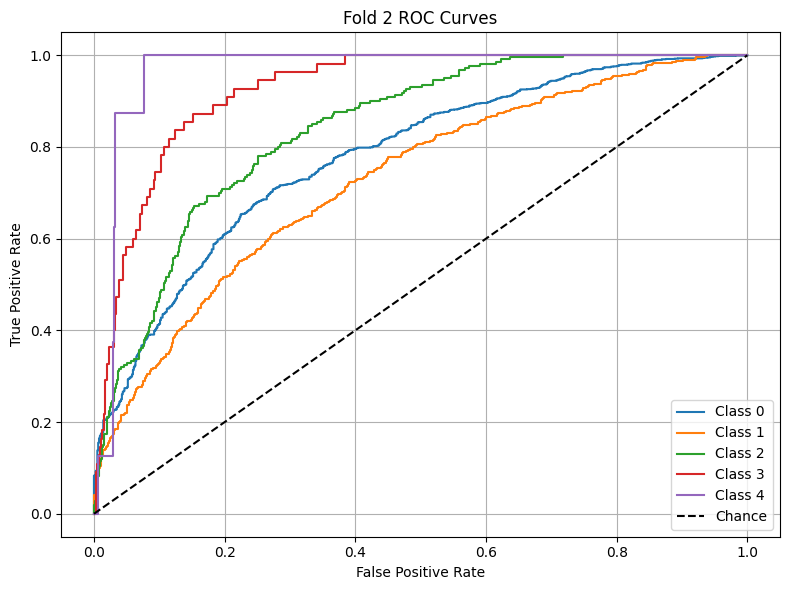


Early stopping occurred at epoch 58 with best_epoch = 48 and best_val_balanced_accuracy = 0.34923


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


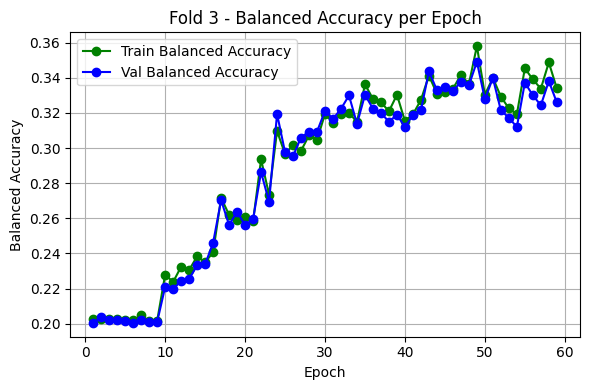

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.81      1489
           1       0.47      0.33      0.39       489
           2       0.44      0.32      0.37       219
           3       0.39      0.22      0.28        54
           4       0.00      0.00      0.00         8

    accuracy                           0.69      2259
   macro avg       0.41      0.35      0.37      2259
weighted avg       0.65      0.69      0.66      2259



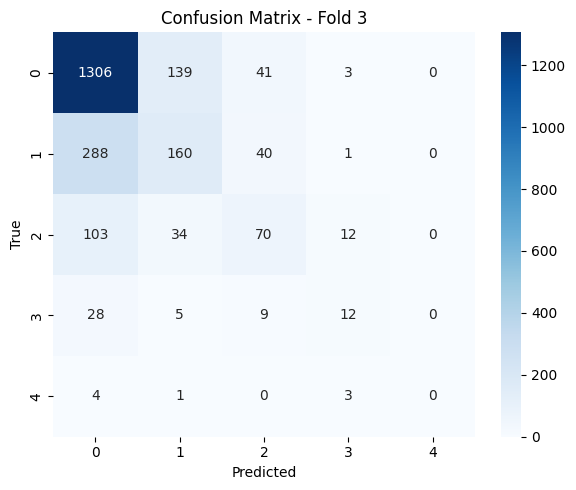

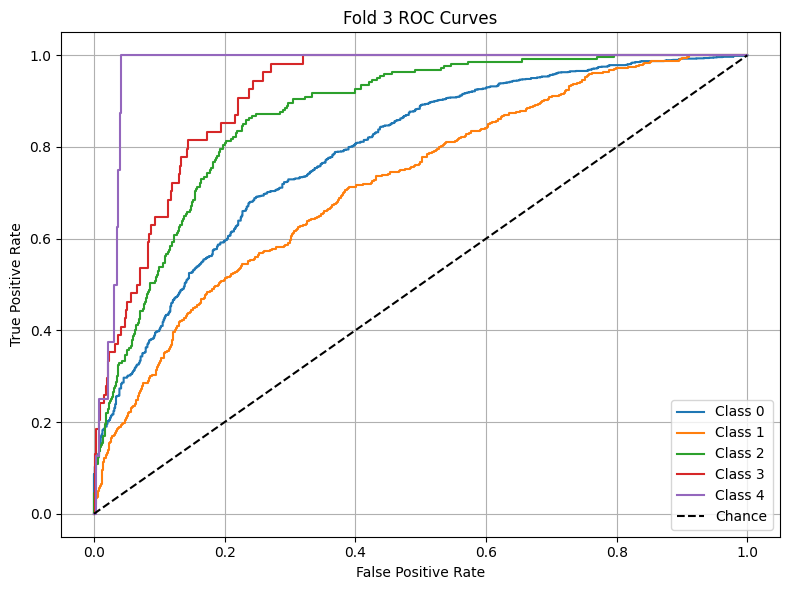


Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_balanced_accuracy = 0.33271


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


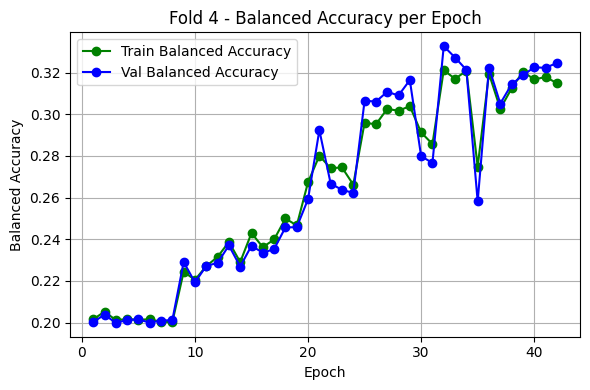

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.94      0.81      1489
           1       0.56      0.18      0.27       489
           2       0.43      0.25      0.32       219
           3       0.53      0.30      0.38        54
           4       0.00      0.00      0.00         8

    accuracy                           0.69      2259
   macro avg       0.45      0.33      0.36      2259
weighted avg       0.65      0.69      0.63      2259



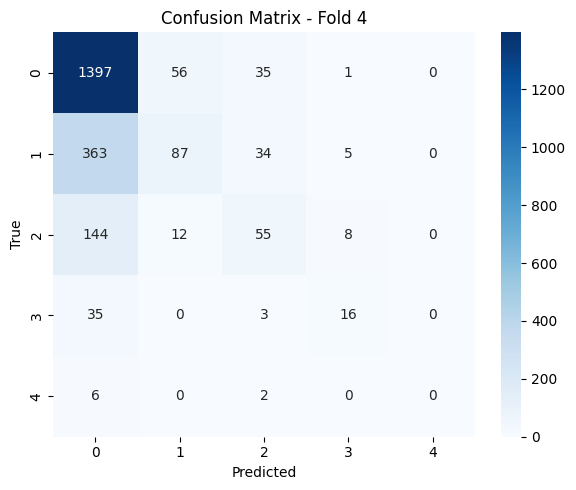

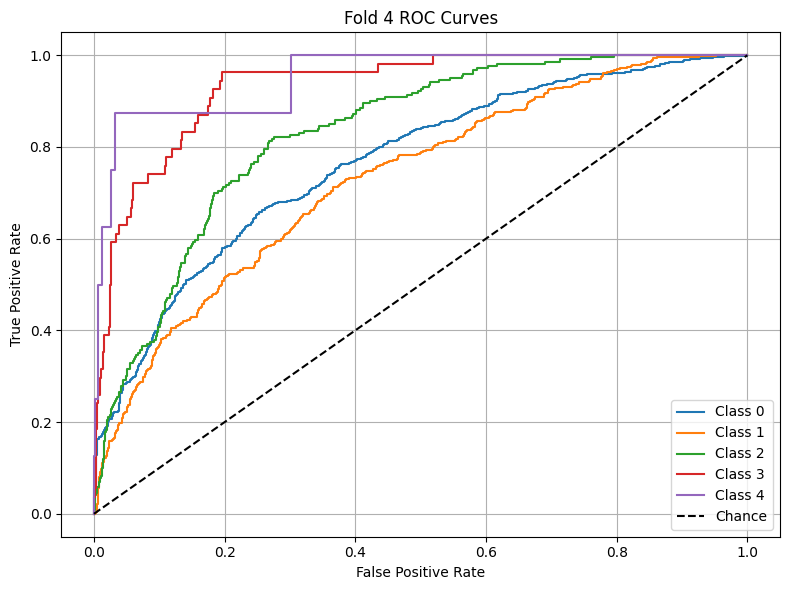


Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_balanced_accuracy = 0.28137


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


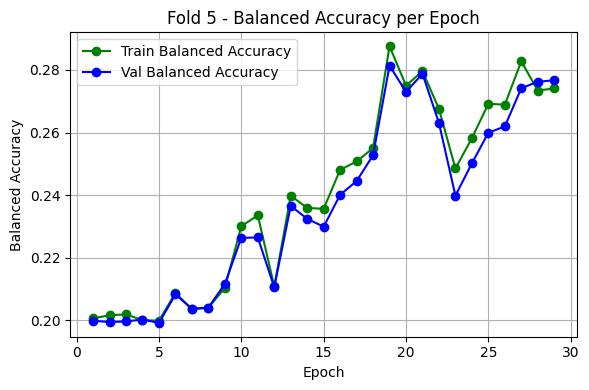

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.89      0.80      1490
           1       0.46      0.27      0.34       488
           2       0.36      0.25      0.30       219
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00         8

    accuracy                           0.67      2259
   macro avg       0.31      0.28      0.29      2259
weighted avg       0.61      0.67      0.63      2259



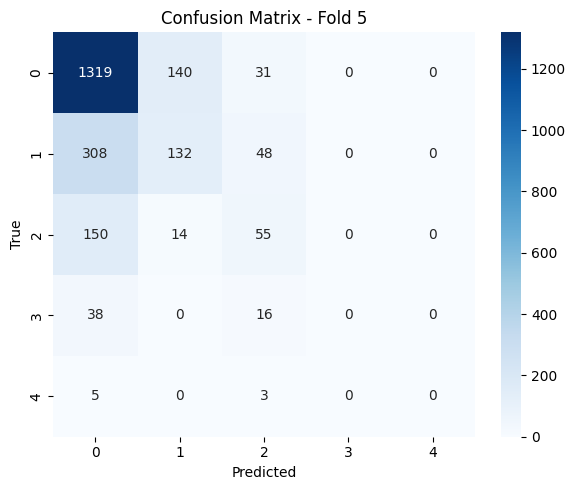

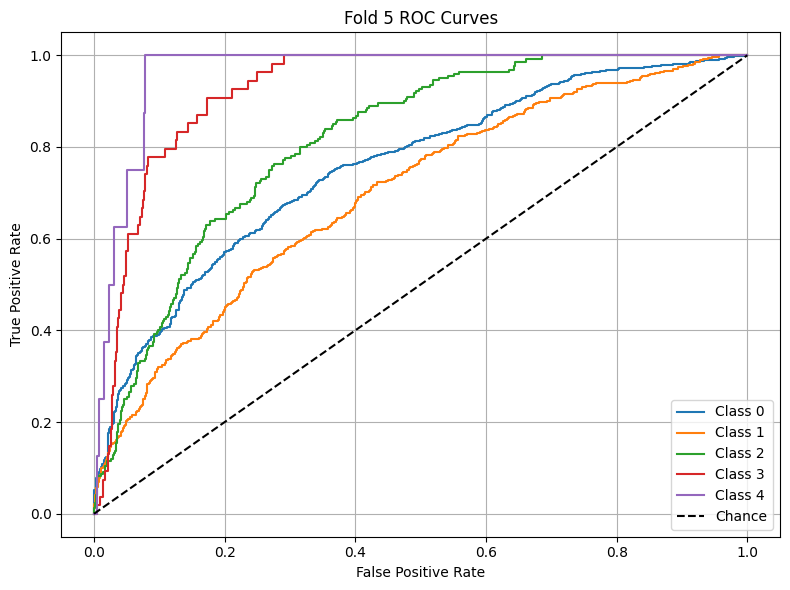


Average Accuracy: 0.6833
Average F1 Macro: 0.3526
Average AUC: 0.8470

Feature Importances:
combined_emb_3     0.217055
video              0.200871
combined_emb_4     0.067794
combined_emb_0     0.053172
exam               0.052367
combined_emb_10    0.048703
exercise_count     0.037253
combined_emb_9     0.029388
combined_emb_2     0.023231
chapter_count      0.022672
dtype: float64

=== Training Phase 3 ===

Early stopping occurred at epoch 54 with best_epoch = 44 and best_val_balanced_accuracy = 0.32826


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


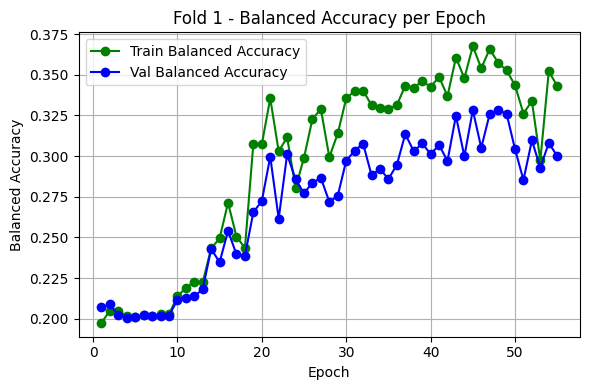

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.83      1361
           1       0.57      0.19      0.28       459
           2       0.41      0.38      0.40       198
           3       0.17      0.14      0.16        49
           4       0.00      0.00      0.00         7

    accuracy                           0.69      2074
   macro avg       0.38      0.33      0.33      2074
weighted avg       0.66      0.69      0.65      2074



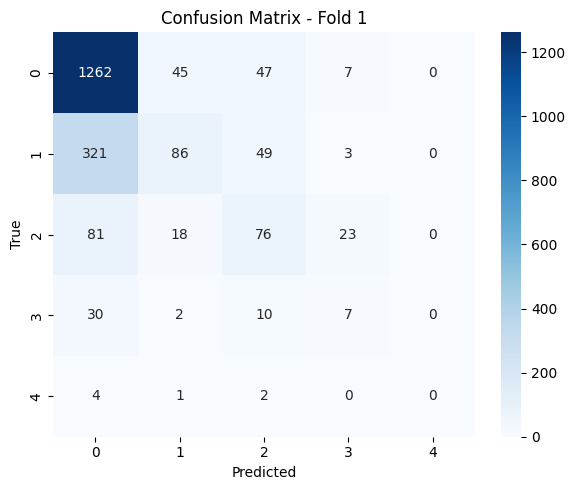

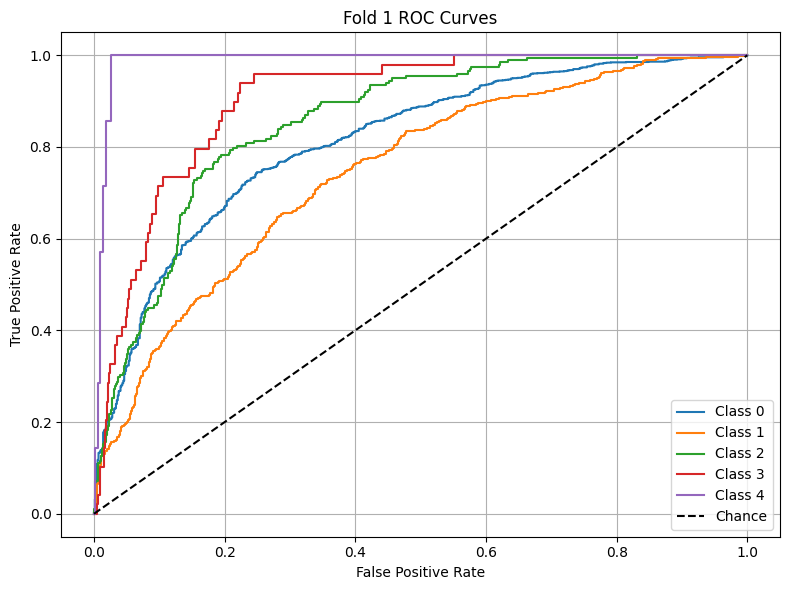


Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_balanced_accuracy = 0.22082


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


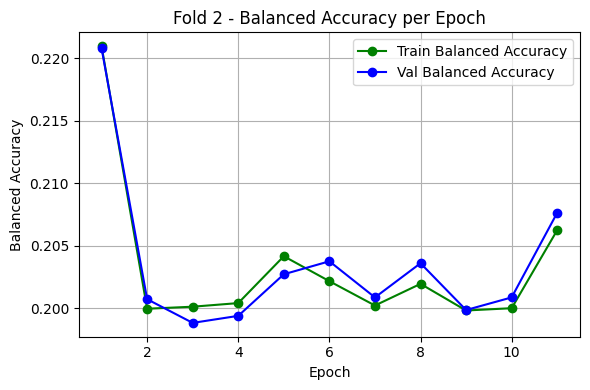

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.84      0.76      1360
           1       0.29      0.26      0.28       459
           2       0.00      0.00      0.00       198
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00         7

    accuracy                           0.61      2074
   macro avg       0.20      0.22      0.21      2074
weighted avg       0.52      0.61      0.56      2074



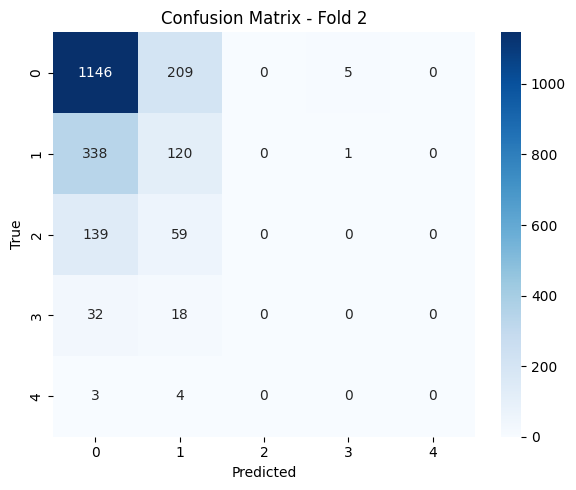

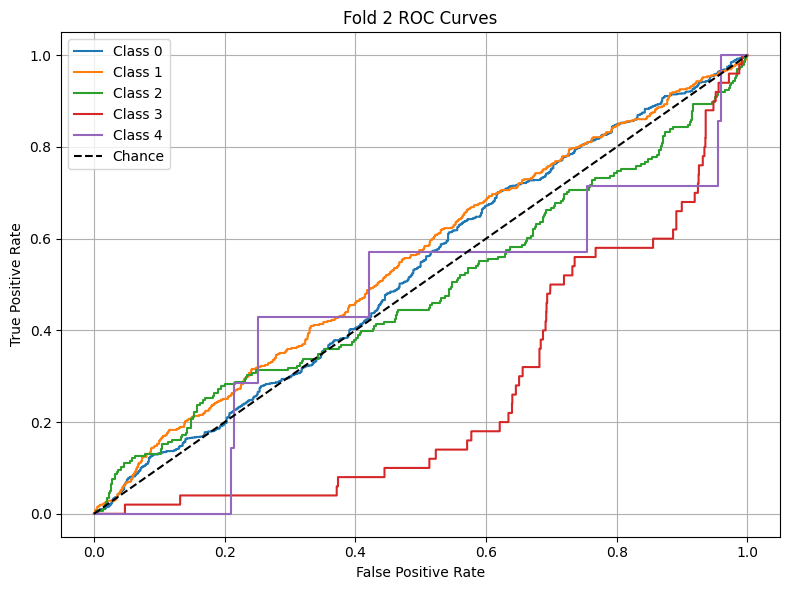


Early stopping occurred at epoch 63 with best_epoch = 53 and best_val_balanced_accuracy = 0.37268


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


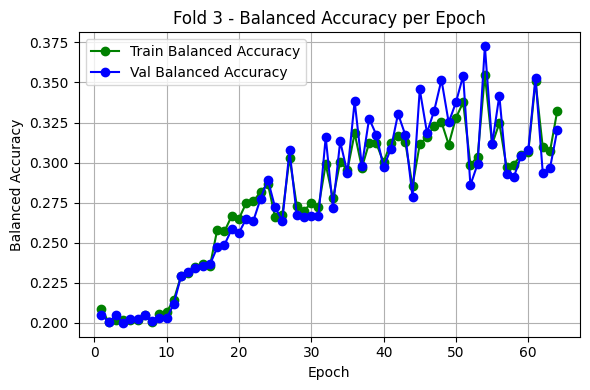

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.94      0.83      1360
           1       0.56      0.21      0.31       459
           2       0.38      0.23      0.29       198
           3       0.46      0.48      0.47        50
           4       0.00      0.00      0.00         7

    accuracy                           0.70      2074
   macro avg       0.43      0.37      0.38      2074
weighted avg       0.66      0.70      0.65      2074



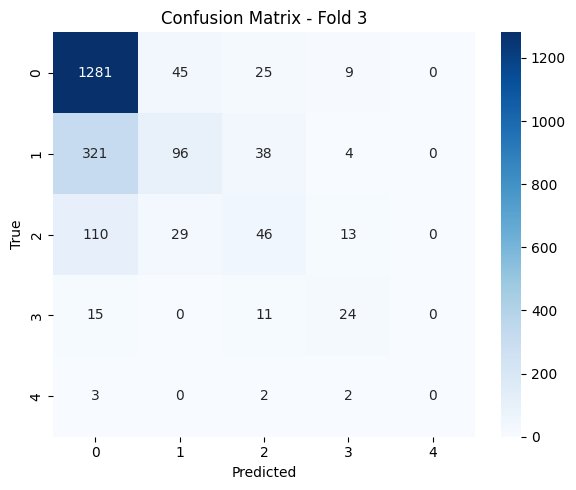

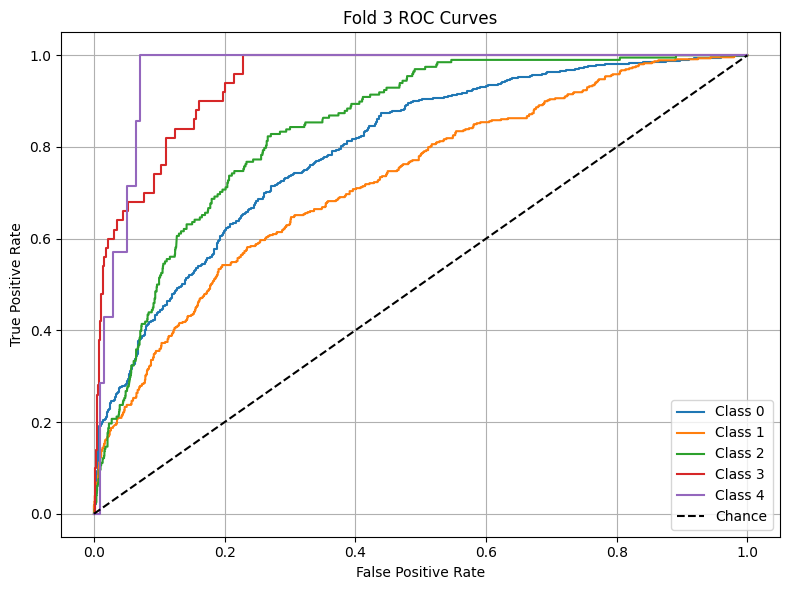


Early stopping occurred at epoch 76 with best_epoch = 66 and best_val_balanced_accuracy = 0.38206


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


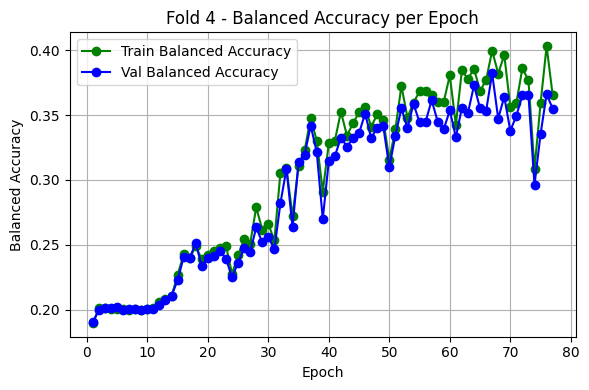

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.83      1360
           1       0.56      0.21      0.30       459
           2       0.50      0.39      0.44       198
           3       0.40      0.38      0.39        50
           4       0.00      0.00      0.00         7

    accuracy                           0.70      2074
   macro avg       0.44      0.38      0.39      2074
weighted avg       0.67      0.70      0.66      2074



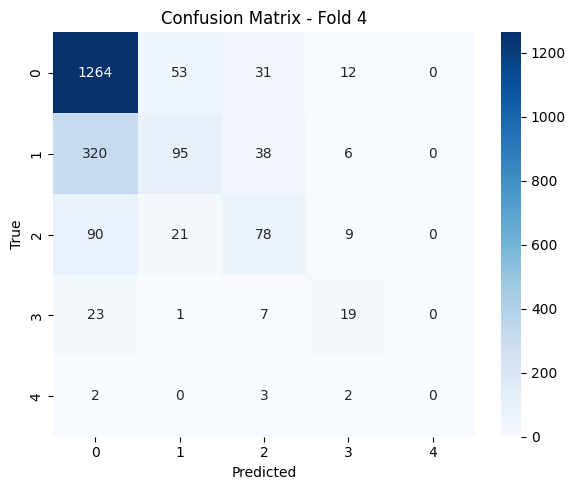

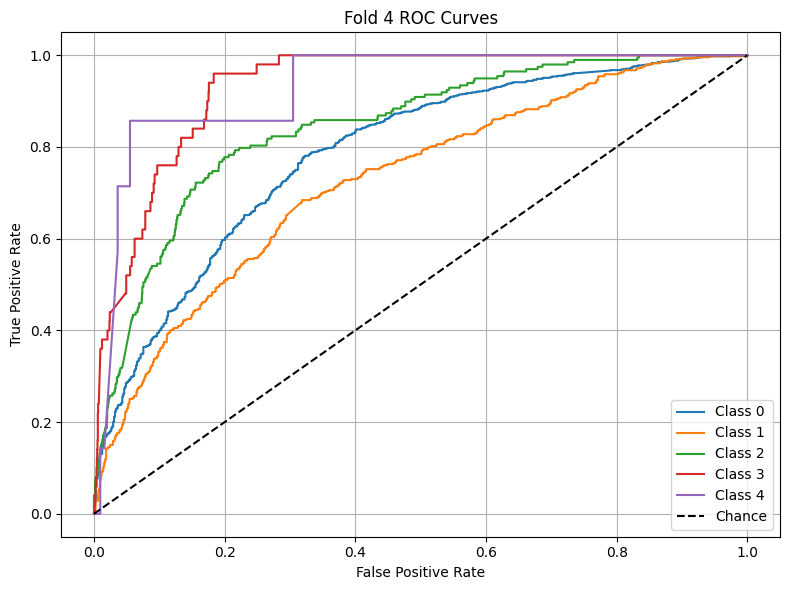


Early stopping occurred at epoch 68 with best_epoch = 58 and best_val_balanced_accuracy = 0.33031


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


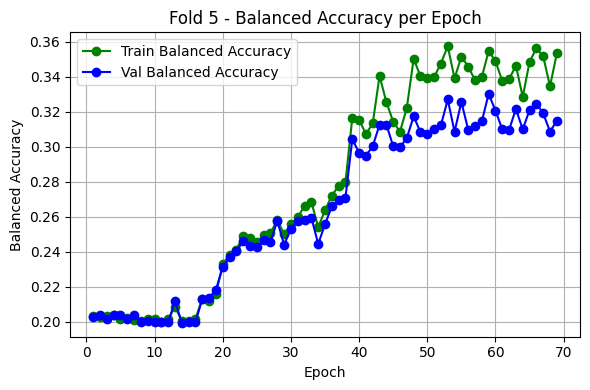

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.92      0.82      1360
           1       0.56      0.20      0.29       460
           2       0.38      0.37      0.38       197
           3       0.47      0.16      0.24        49
           4       0.00      0.00      0.00         7

    accuracy                           0.69      2073
   macro avg       0.43      0.33      0.35      2073
weighted avg       0.65      0.69      0.64      2073



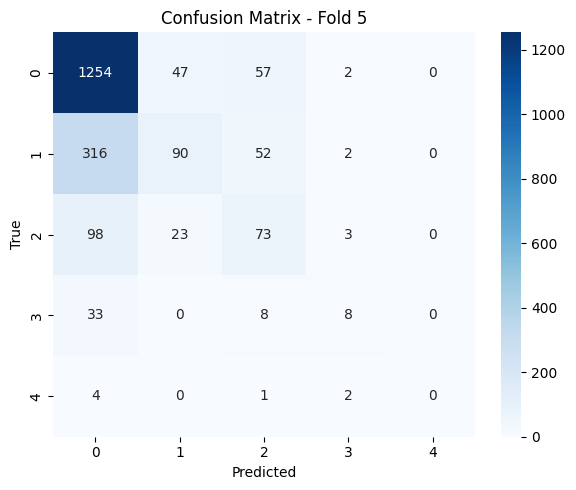

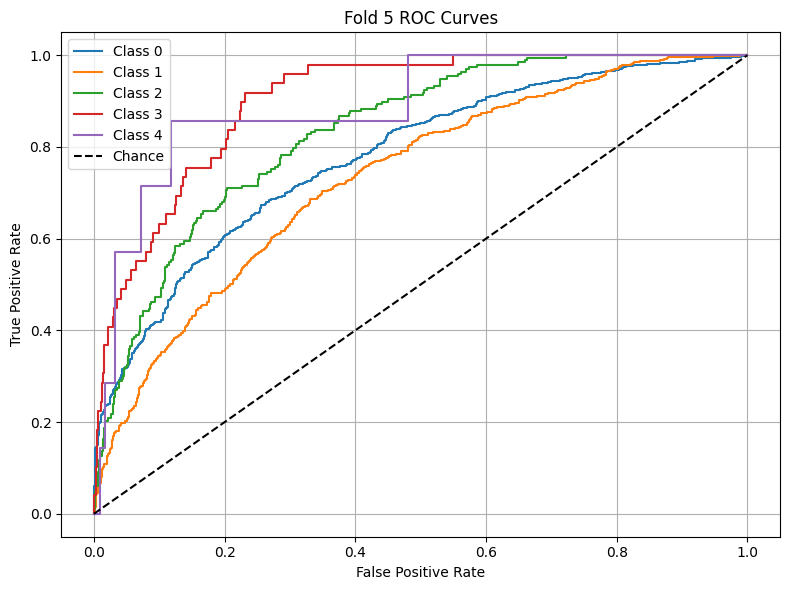


Average Accuracy: 0.6775
Average F1 Macro: 0.3309
Average AUC: 0.7695

Feature Importances:
combined_emb_7                0.142645
combined_emb_13               0.093216
combined_emb_8                0.080475
remaining_time                0.057382
exercise_count                0.047138
video_watched_percentage_3    0.043535
combined_emb_10               0.038171
duration_days                 0.036194
combined_emb_1                0.035144
total_neutral3                0.031657
dtype: float64

=== Training Phase 4 ===

Early stopping occurred at epoch 88 with best_epoch = 78 and best_val_balanced_accuracy = 0.38346


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


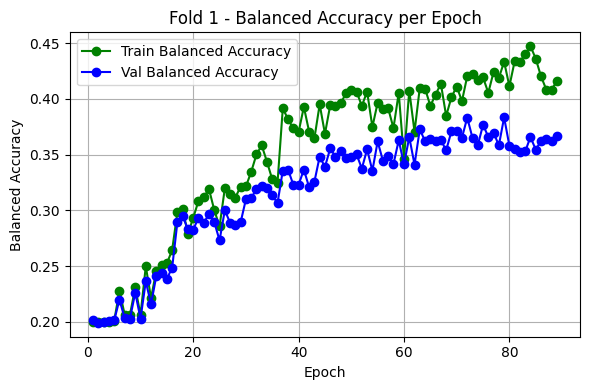

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82      1000
           1       0.51      0.40      0.45       355
           2       0.39      0.23      0.29       139
           3       0.40      0.41      0.41        39
           4       0.00      0.00      0.00         6

    accuracy                           0.69      1539
   macro avg       0.41      0.38      0.39      1539
weighted avg       0.66      0.69      0.67      1539



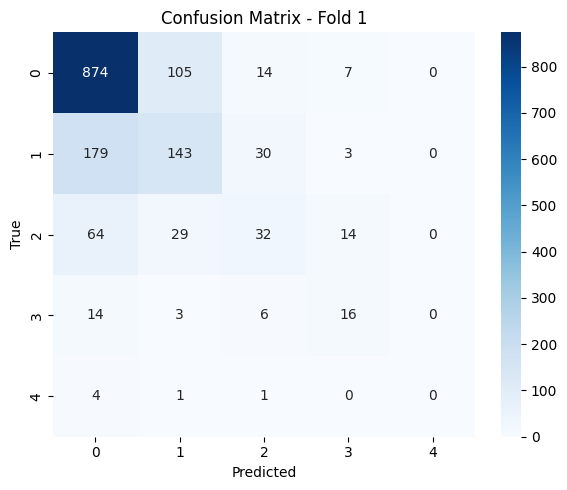

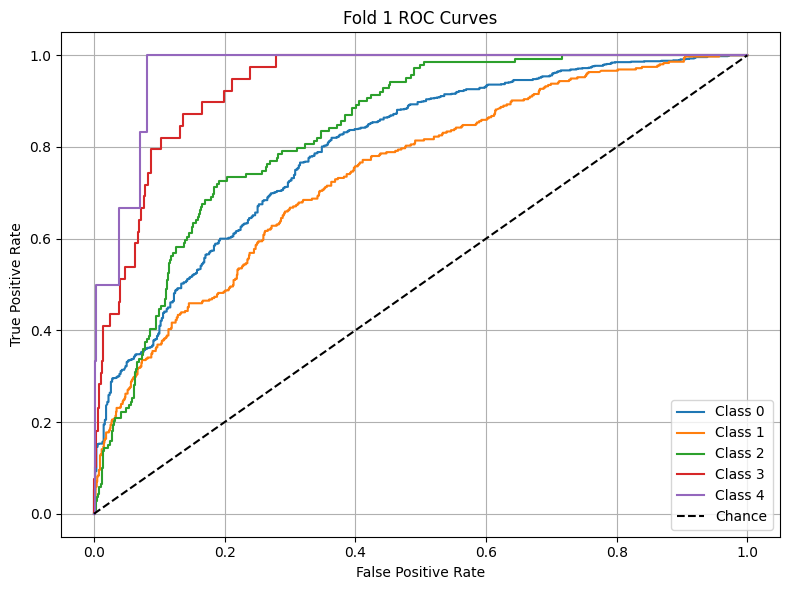


Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_balanced_accuracy = 0.37199


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


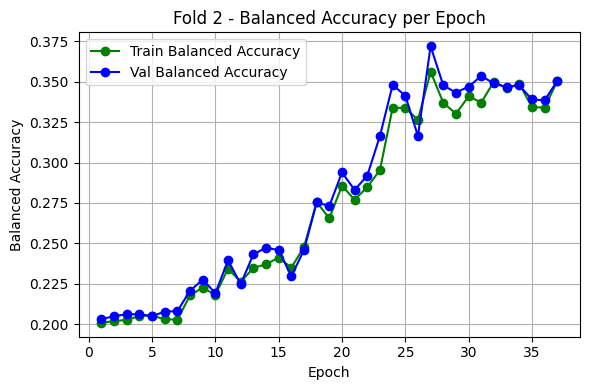

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.83      1000
           1       0.59      0.31      0.40       355
           2       0.65      0.14      0.24       139
           3       0.32      0.47      0.38        40
           4       0.00      0.00      0.00         5

    accuracy                           0.70      1539
   macro avg       0.46      0.37      0.37      1539
weighted avg       0.68      0.70      0.66      1539



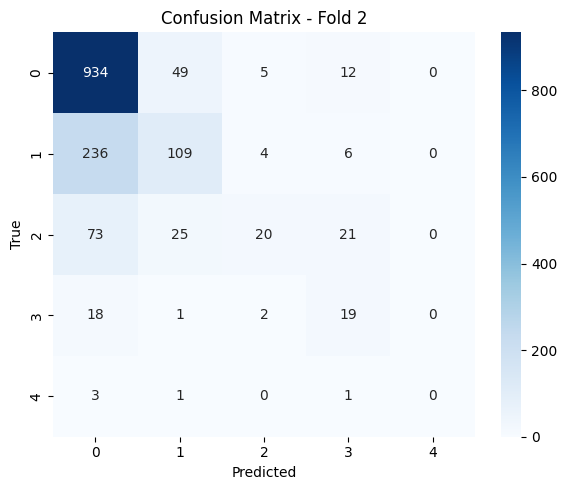

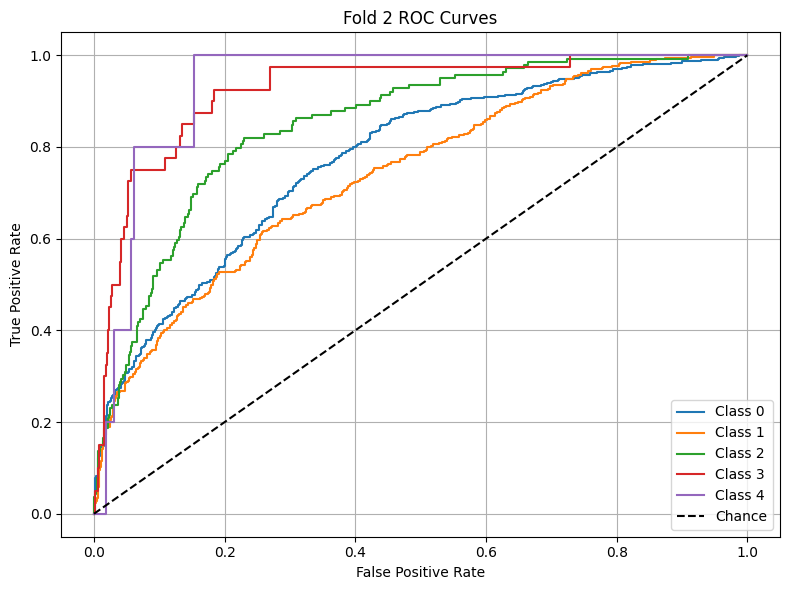


Early stopping occurred at epoch 73 with best_epoch = 63 and best_val_balanced_accuracy = 0.38948


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


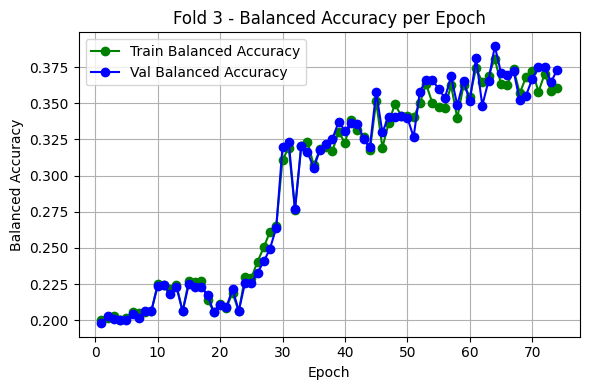

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.84      0.80       999
           1       0.51      0.46      0.49       355
           2       0.43      0.29      0.35       139
           3       0.54      0.35      0.42        40
           4       0.00      0.00      0.00         6

    accuracy                           0.69      1539
   macro avg       0.45      0.39      0.41      1539
weighted avg       0.67      0.69      0.68      1539



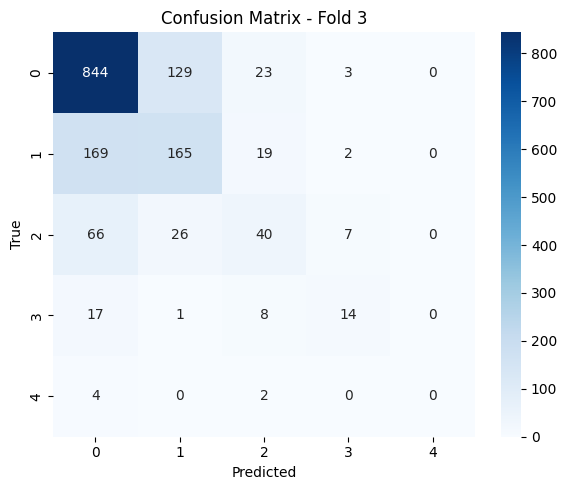

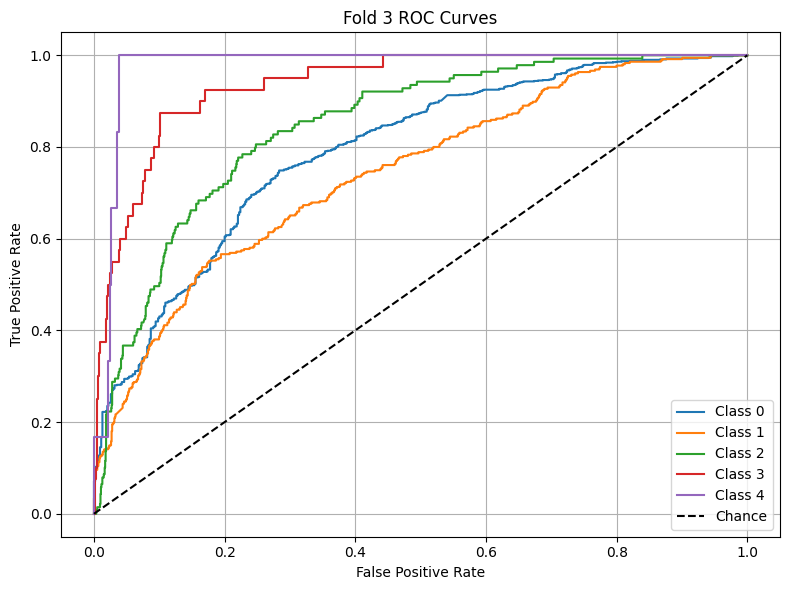


Early stopping occurred at epoch 98 with best_epoch = 88 and best_val_balanced_accuracy = 0.32653


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


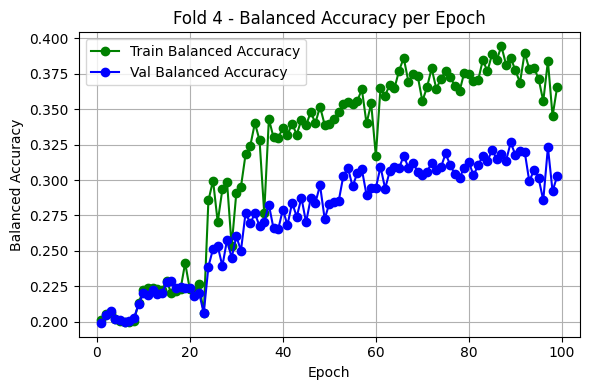

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.96      0.84       999
           1       0.67      0.27      0.38       356
           2       0.45      0.33      0.38       138
           3       0.17      0.08      0.11        39
           4       0.00      0.00      0.00         6

    accuracy                           0.72      1538
   macro avg       0.41      0.33      0.34      1538
weighted avg       0.69      0.72      0.67      1538



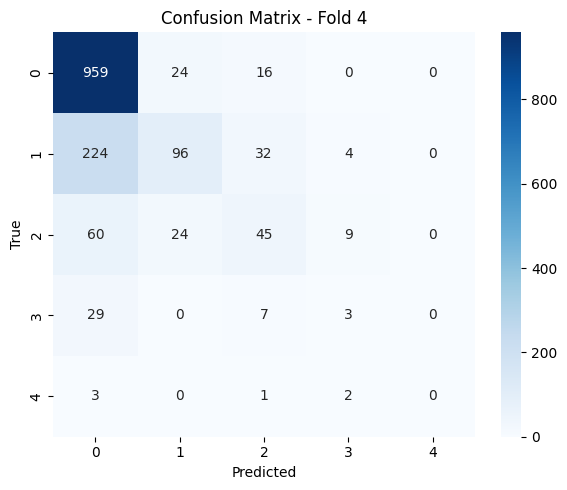

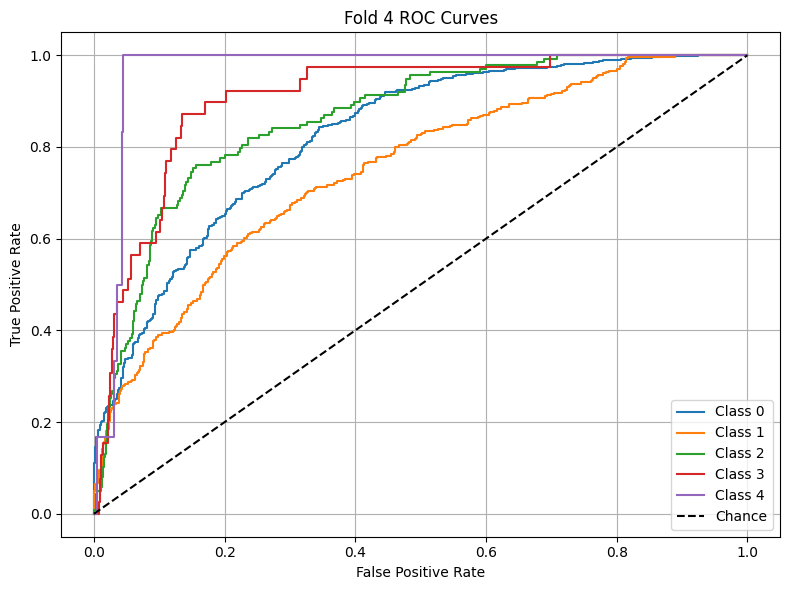


Early stopping occurred at epoch 71 with best_epoch = 61 and best_val_balanced_accuracy = 0.40828


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


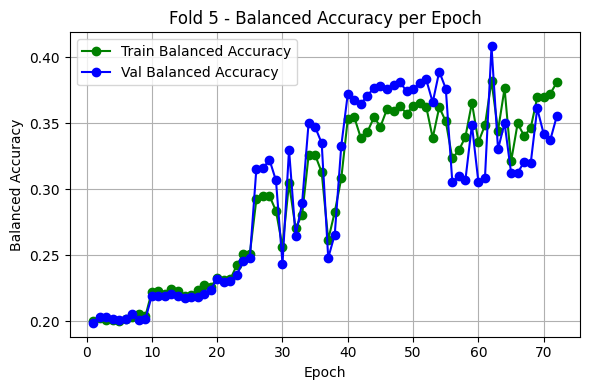

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83       999
           1       0.59      0.34      0.43       356
           2       0.36      0.28      0.32       138
           3       0.51      0.51      0.51        39
           4       0.00      0.00      0.00         6

    accuracy                           0.71      1538
   macro avg       0.45      0.41      0.42      1538
weighted avg       0.68      0.71      0.68      1538



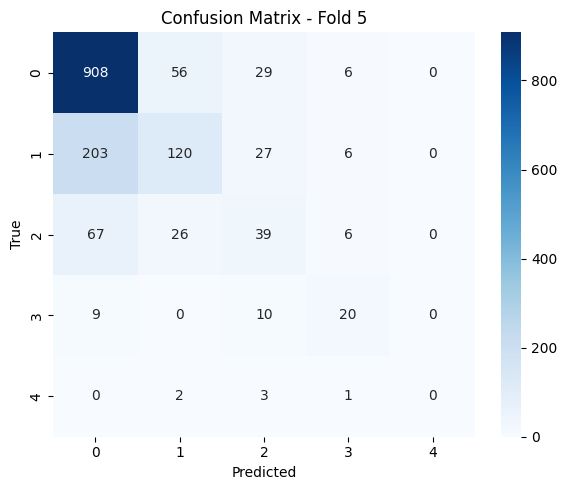

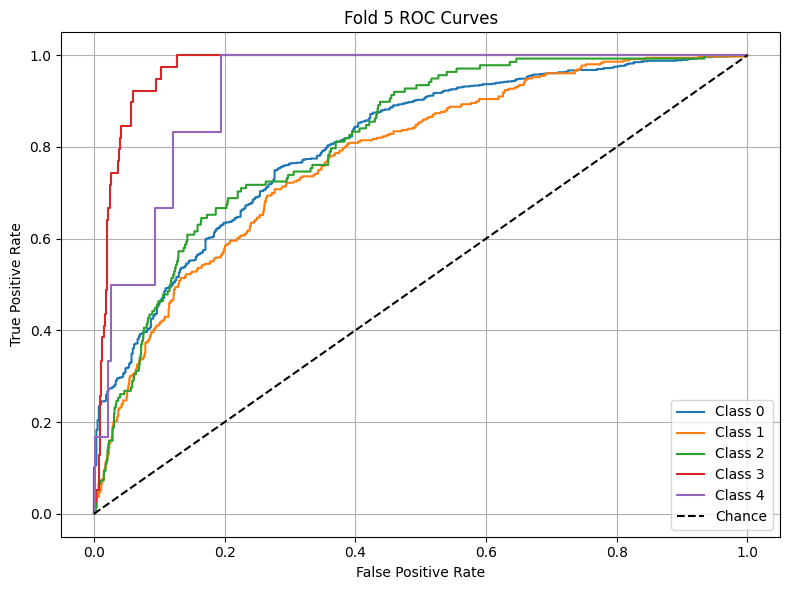


Average Accuracy: 0.7019
Average F1 Macro: 0.3868
Average AUC: 0.8561

Feature Importances:
combined_emb_5             0.162343
combined_emb_12            0.101336
combined_emb_10            0.094138
combined_emb_4             0.074942
combined_emb_6             0.067172
assignment                 0.060220
exercise_correct_mean_1    0.042728
chapter_count              0.042004
video                      0.041428
num_prerequisites          0.040233
dtype: float64


In [6]:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [7]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       568
           1       0.18      0.24      0.21        63
           2       0.24      0.16      0.19        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.74       698
   macro avg       0.25      0.25      0.25       698
weighted avg       0.72      0.74      0.73       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


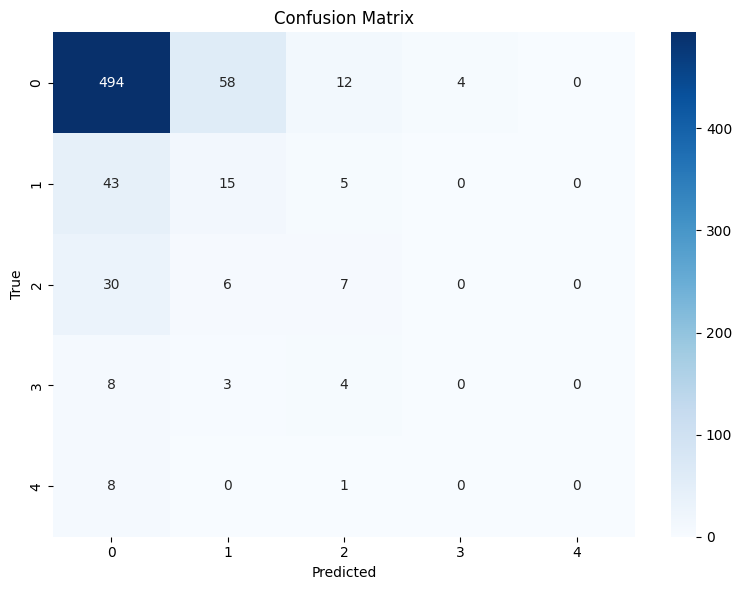


Test AUC (macro-average, OVR): 0.6882


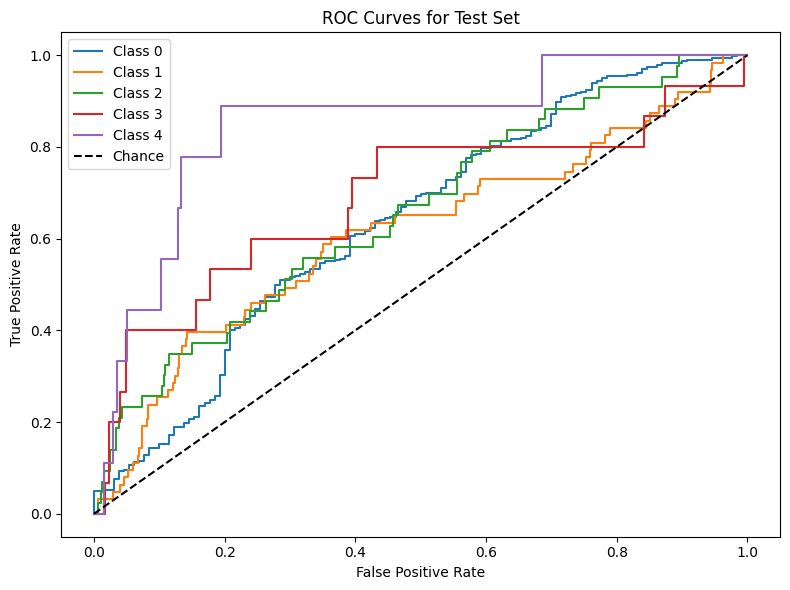


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       544
           1       0.13      0.20      0.16        59
           2       0.13      0.17      0.15        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.68       668
   macro avg       0.22      0.24      0.23       668
weighted avg       0.71      0.68      0.69       668



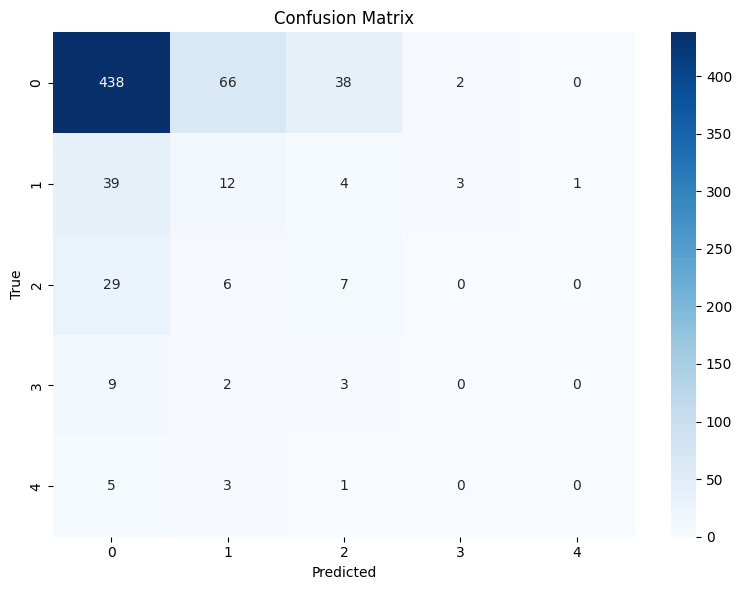


Test AUC (macro-average, OVR): 0.6155


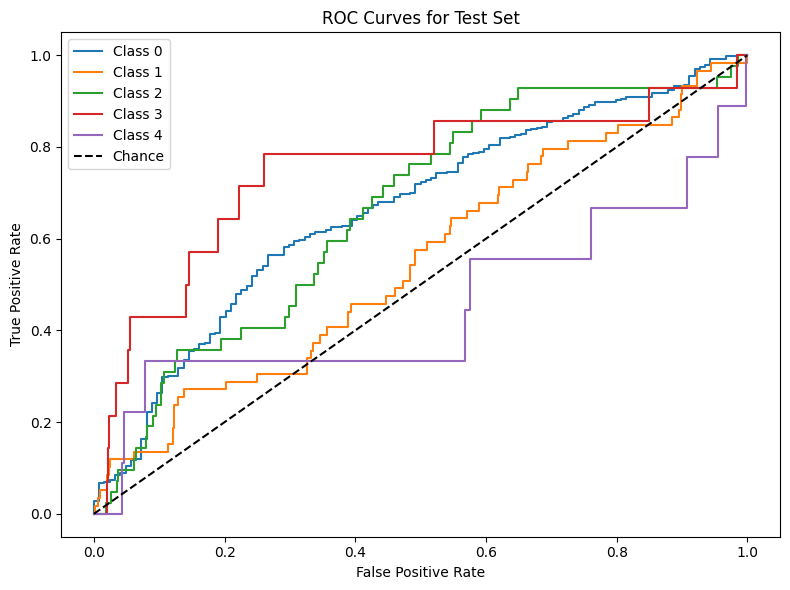


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.80      0.83       455
           1       0.17      0.35      0.23        52
           2       0.06      0.03      0.04        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.69       554
   macro avg       0.22      0.24      0.22       554
weighted avg       0.72      0.69      0.70       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


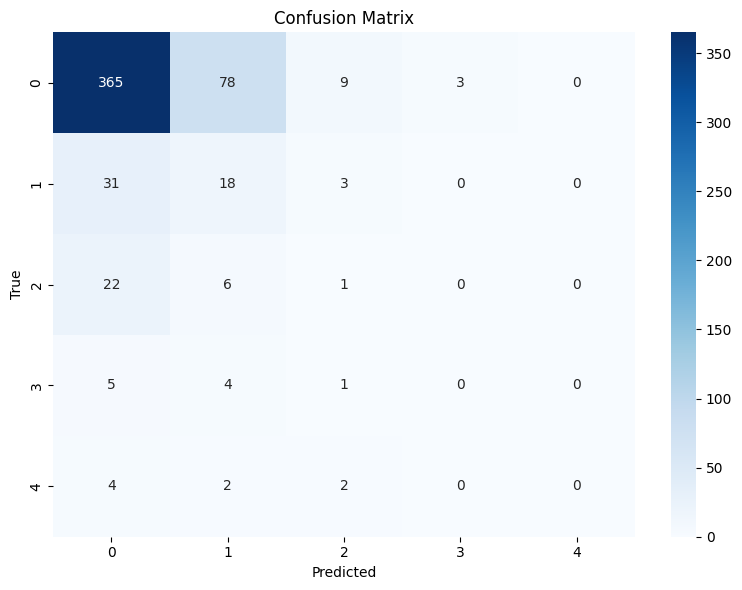


Test AUC (macro-average, OVR): 0.5913


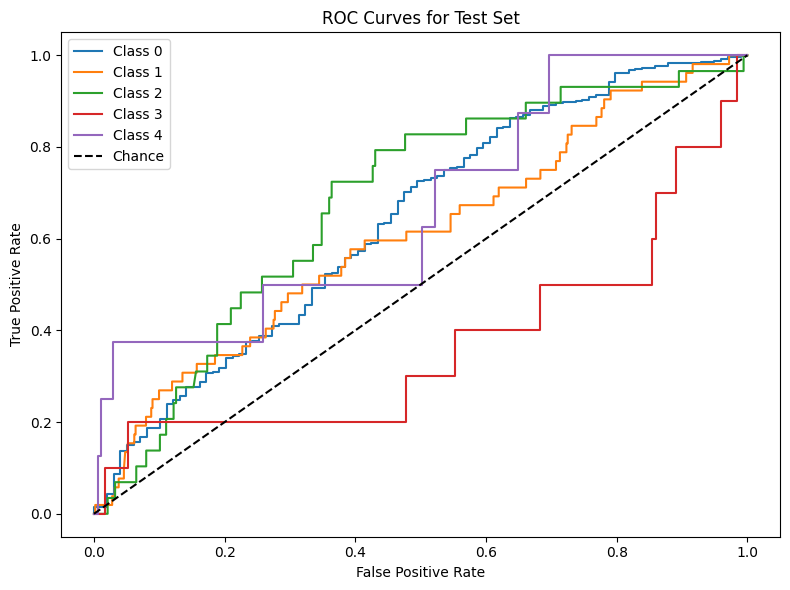


Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       395
           1       0.09      0.12      0.11        40
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.69       477
   macro avg       0.18      0.19      0.19       477
weighted avg       0.69      0.69      0.69       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


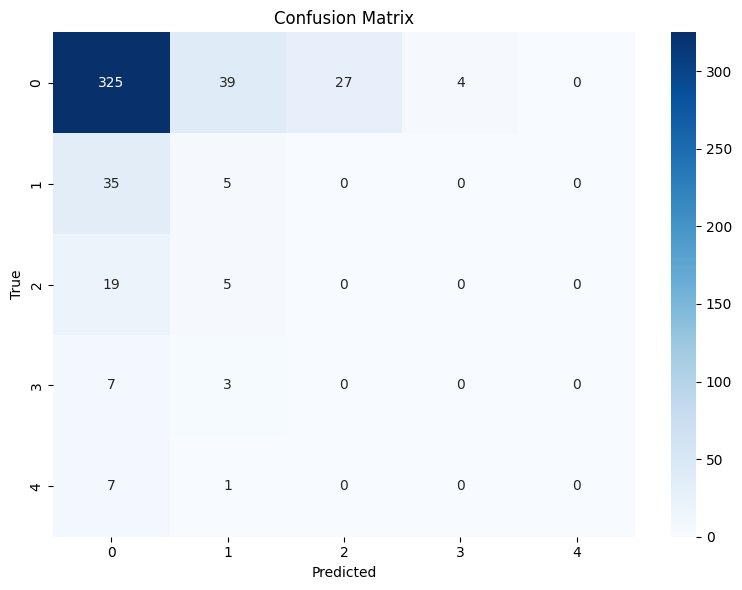


Test AUC (macro-average, OVR): 0.4826


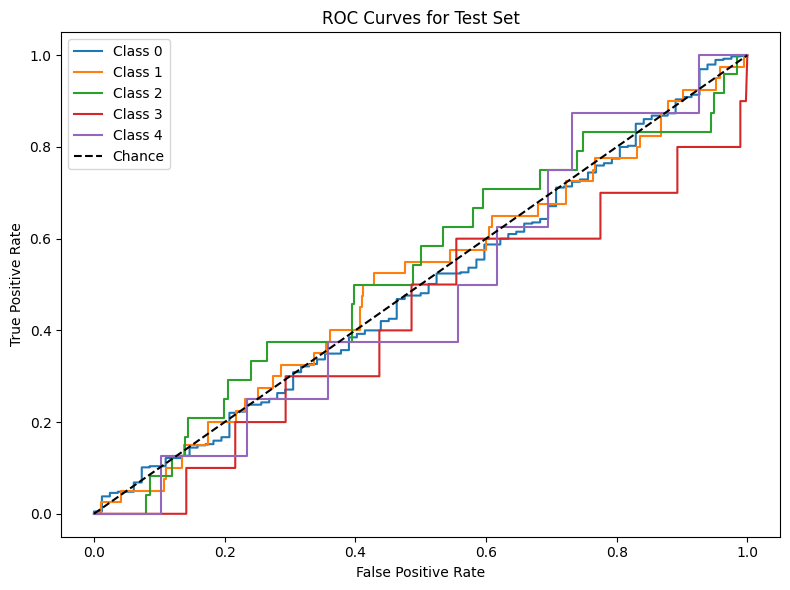

In [8]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample

In [9]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import LabelEncoder, label_binarize

def train_not_balance_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_fold = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled_np = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled_np = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled_np, columns=X_val.columns)

        # Encode target labels
        label_encoder = LabelEncoder()
        y_train_enc = label_encoder.fit_transform(y_train)
        y_val_enc = label_encoder.transform(y_val)
        class_names = label_encoder.classes_

        # Convert to NumPy arrays
        X_train_np = X_train_scaled.values
        X_val_np = X_val_scaled.values

        # Define and train TabNet model
        model = TabNetClassifier(
            seed=random_state,
            verbose=0
        )

        model.fit(
            X_train=X_train_np, y_train=y_train_enc,
            eval_set=[(X_train_np, y_train_enc), (X_val_np, y_val_enc)],
            eval_name=['train', 'val'],
            eval_metric=['accuracy'],
            max_epochs=100,
            patience=10,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0
        )

        # Plot training history
        history = model.history.history
        val_acc = history.get('val_accuracy', None)
        train_acc = history.get('train_accuracy', None)
        epochs = list(range(1, len(val_acc) + 1)) if val_acc else []
        
        if val_acc and train_acc:
            plt.figure(figsize=(6, 4))
            plt.plot(epochs, train_acc, label='Train Accuracy', marker='o', color='green')
            plt.plot(epochs, val_acc, label='Val Accuracy', marker='o', color='blue')
            plt.title(f'Fold {fold} - Balanced Accuracy per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Balanced Accuracy')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

        # Evaluate
        y_pred_enc = model.predict(X_val_np)
        y_pred = label_encoder.inverse_transform(y_pred_enc)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # AUC
        y_proba = model.predict_proba(X_val_np)
        y_val_bin = label_binarize(y_val_enc, classes=np.arange(len(class_names)))
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold
            best_label_encoder = label_encoder

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, class_label in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {class_label}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.title(f'Fold {fold} ROC Curves')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature Importances
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances.head(10))

    return best_model, best_scaler, best_fold, all_metrics



=== Training Phase 1 ===

Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_accuracy = 0.64715


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


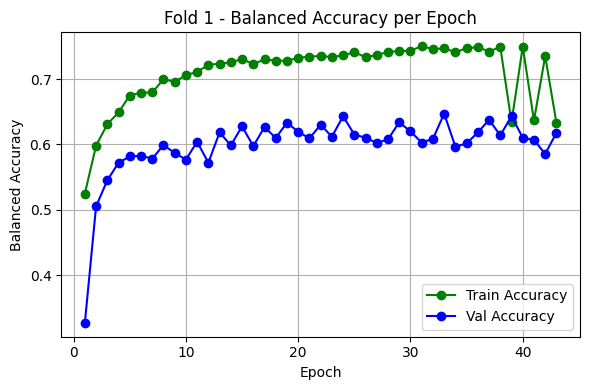


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.73      0.78      1785
           1       0.51      0.48      0.50       604
           2       0.34      0.47      0.40       258
           3       0.18      0.63      0.28        59
           4       0.00      0.00      0.00         9

    accuracy                           0.65      2715
   macro avg       0.38      0.46      0.39      2715
weighted avg       0.71      0.65      0.67      2715



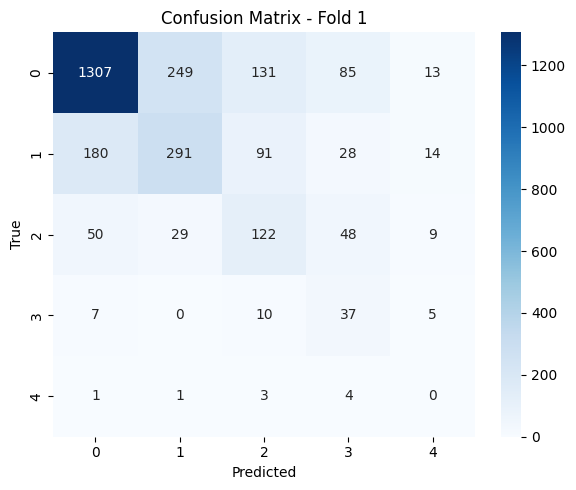

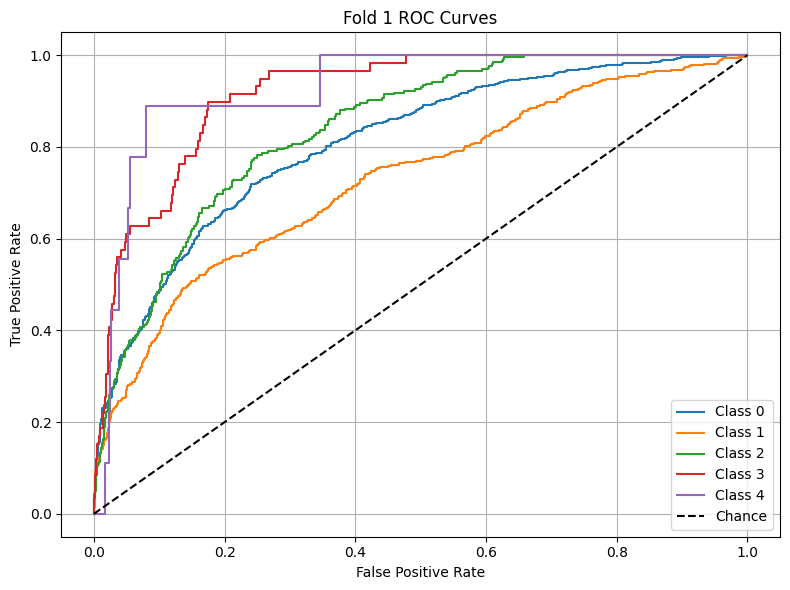


Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_accuracy = 0.59211


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


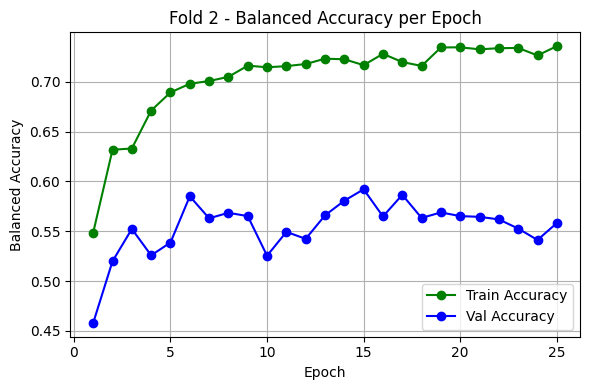


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.66      0.73      1786
           1       0.43      0.45      0.44       603
           2       0.30      0.50      0.37       258
           3       0.17      0.53      0.26        59
           4       0.04      0.12      0.06         8

    accuracy                           0.59      2714
   macro avg       0.35      0.45      0.37      2714
weighted avg       0.67      0.59      0.62      2714



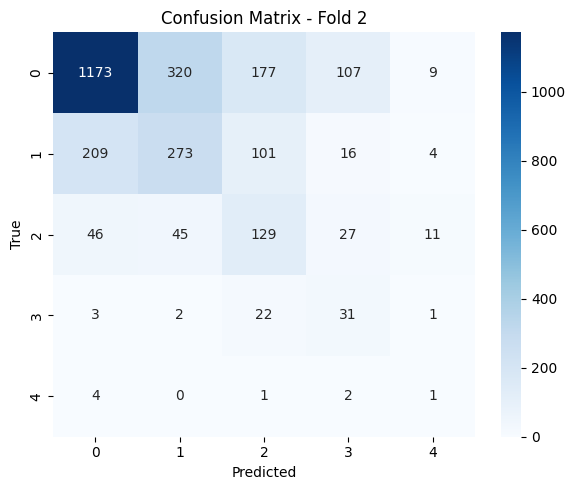

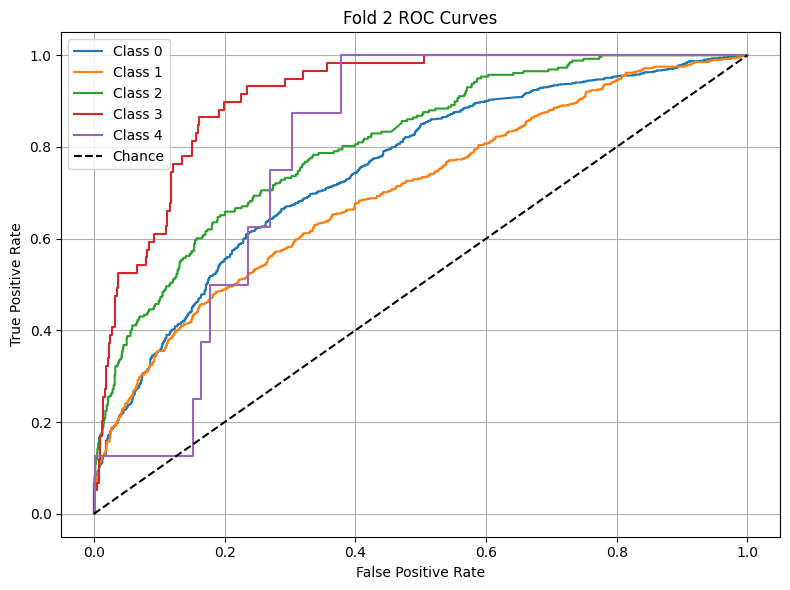


Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_accuracy = 0.62159


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


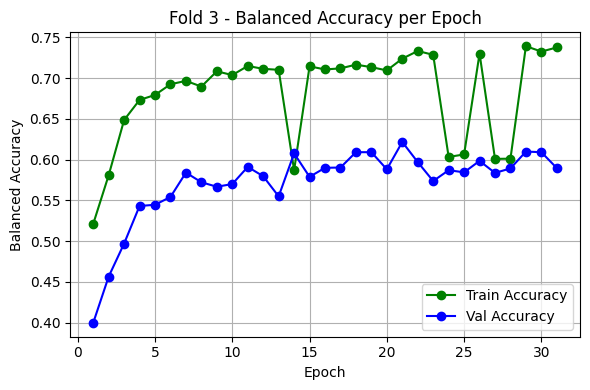


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77      1786
           1       0.47      0.43      0.45       603
           2       0.31      0.51      0.39       258
           3       0.19      0.56      0.28        59
           4       0.04      0.38      0.08         8

    accuracy                           0.62      2714
   macro avg       0.37      0.52      0.39      2714
weighted avg       0.69      0.62      0.65      2714



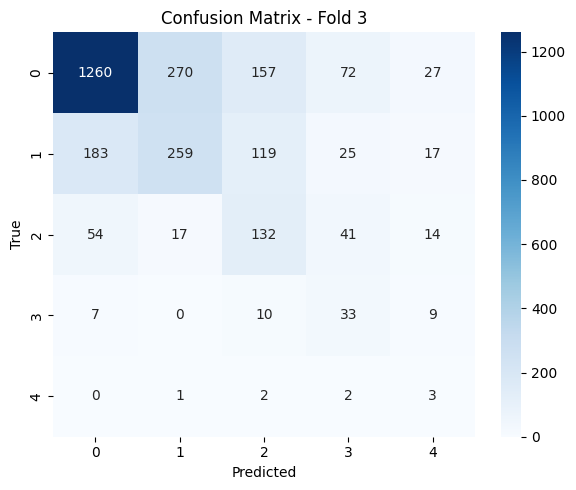

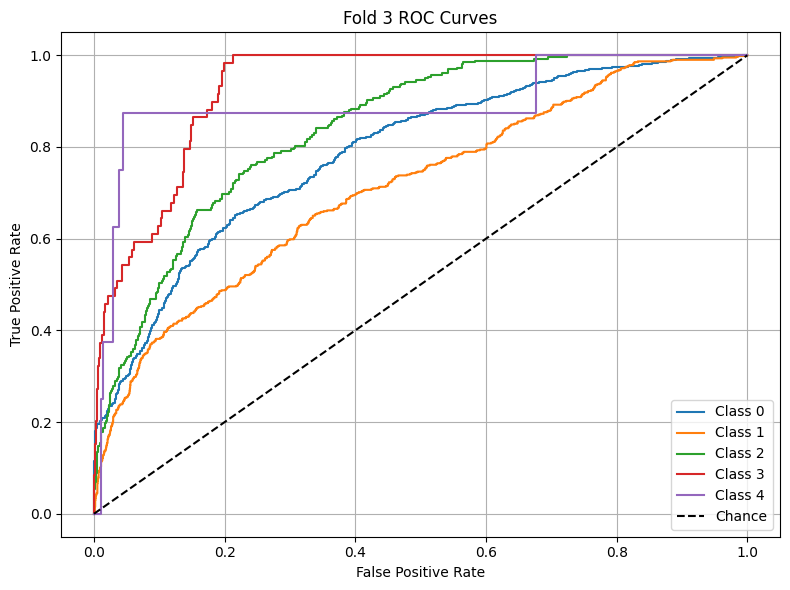


Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_accuracy = 0.64186


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


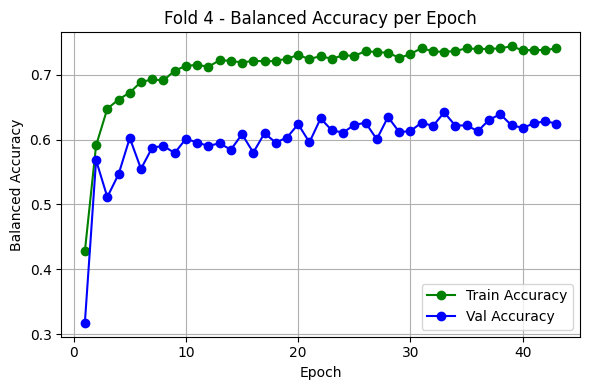


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.72      0.77      1785
           1       0.48      0.48      0.48       603
           2       0.37      0.51      0.43       258
           3       0.18      0.61      0.28        59
           4       0.09      0.33      0.14         9

    accuracy                           0.64      2714
   macro avg       0.39      0.53      0.42      2714
weighted avg       0.70      0.64      0.66      2714



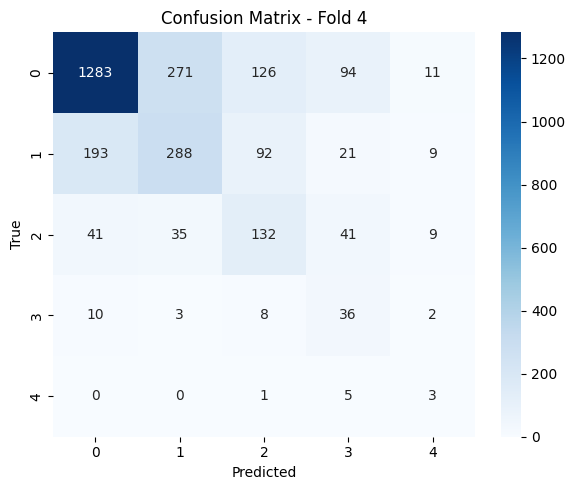

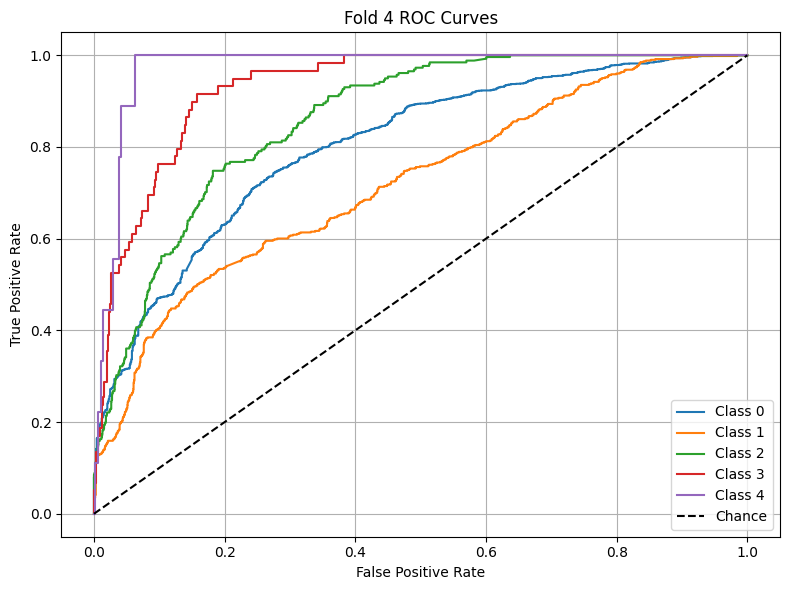


Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_accuracy = 0.6308


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


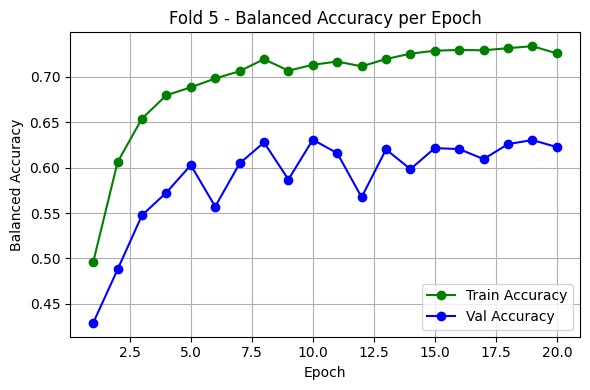


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77      1785
           1       0.49      0.42      0.45       603
           2       0.31      0.54      0.39       258
           3       0.21      0.53      0.30        59
           4       0.19      0.44      0.27         9

    accuracy                           0.63      2714
   macro avg       0.40      0.53      0.43      2714
weighted avg       0.68      0.63      0.65      2714



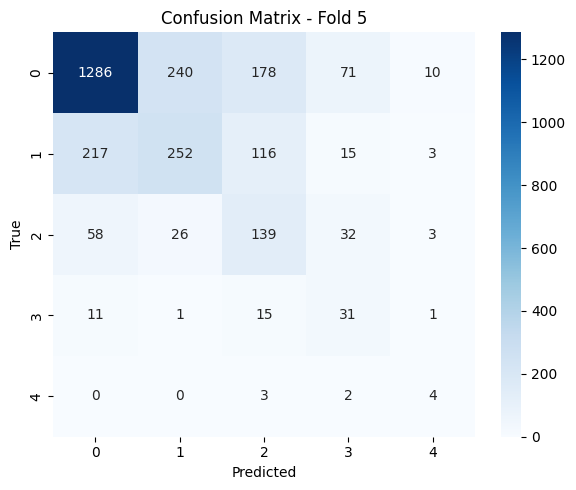

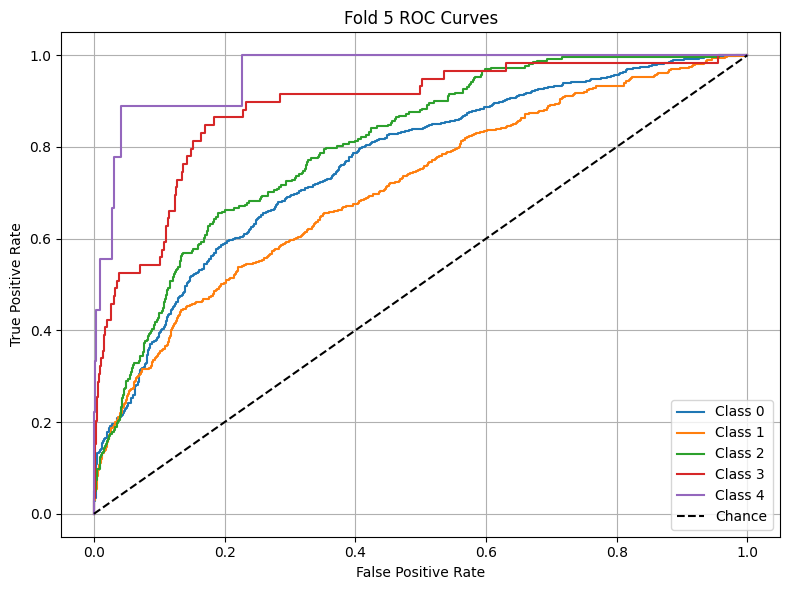


Average Accuracy: 0.6267
Average F1 Macro: 0.4023
Average AUC: 0.8303

Feature Importances:
combined_emb_13      0.088967
combined_emb_10      0.070065
encoded_field_sum    0.067828
certificate          0.059430
num_prerequisites    0.050069
combined_emb_14      0.047746
combined_emb_11      0.046495
combined_emb_9       0.045481
combined_emb_4       0.039699
combined_emb_7       0.038675
dtype: float64

=== Training Phase 2 ===

Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_accuracy = 0.63009


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


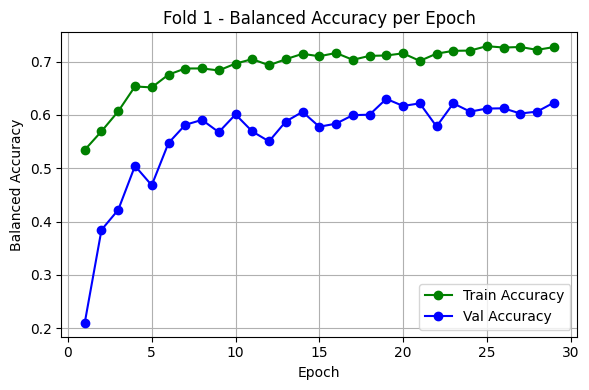


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.73      0.77      1489
           1       0.44      0.41      0.42       488
           2       0.33      0.50      0.40       220
           3       0.23      0.56      0.33        54
           4       0.04      0.11      0.06         9

    accuracy                           0.63      2260
   macro avg       0.37      0.46      0.40      2260
weighted avg       0.68      0.63      0.65      2260



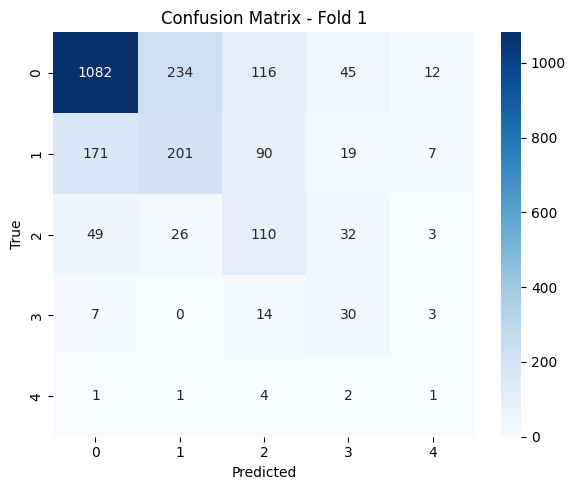

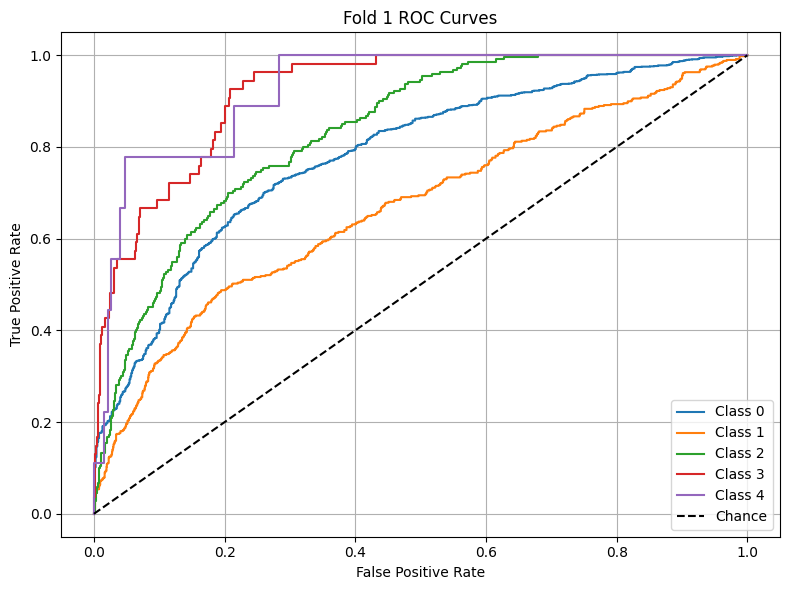


Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_accuracy = 0.6177


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


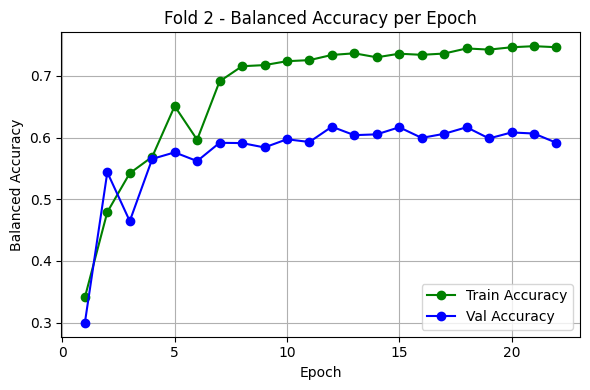


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.76      1489
           1       0.44      0.42      0.43       489
           2       0.31      0.48      0.38       219
           3       0.18      0.64      0.28        55
           4       0.21      0.38      0.27         8

    accuracy                           0.62      2260
   macro avg       0.40      0.52      0.43      2260
weighted avg       0.68      0.62      0.64      2260



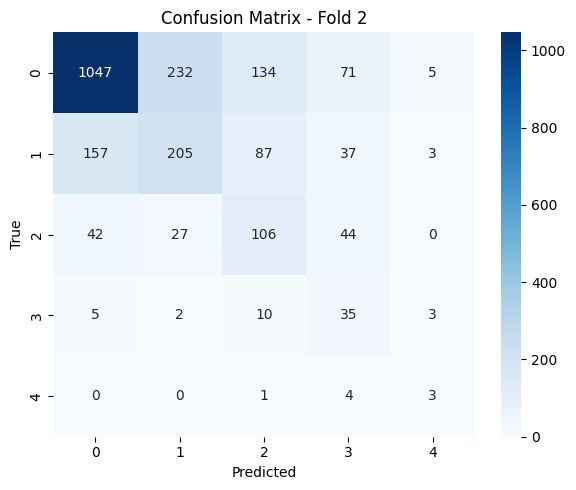

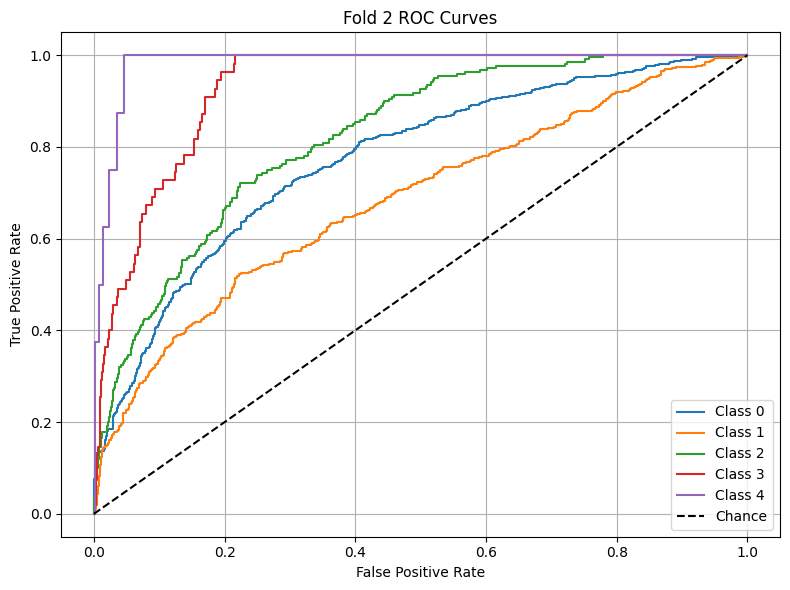


Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_accuracy = 0.6255


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


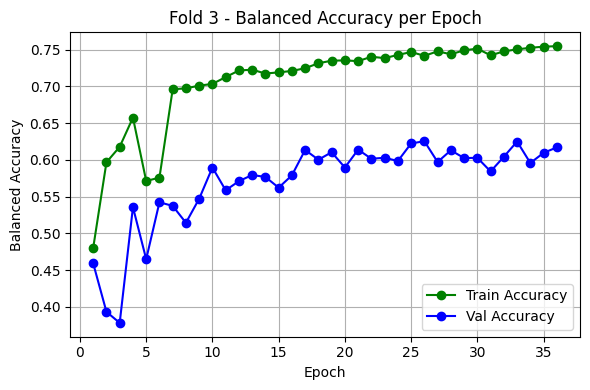


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.77      1489
           1       0.45      0.39      0.42       489
           2       0.33      0.54      0.41       219
           3       0.20      0.48      0.28        54
           4       0.09      0.62      0.16         8

    accuracy                           0.63      2259
   macro avg       0.38      0.55      0.41      2259
weighted avg       0.68      0.63      0.65      2259



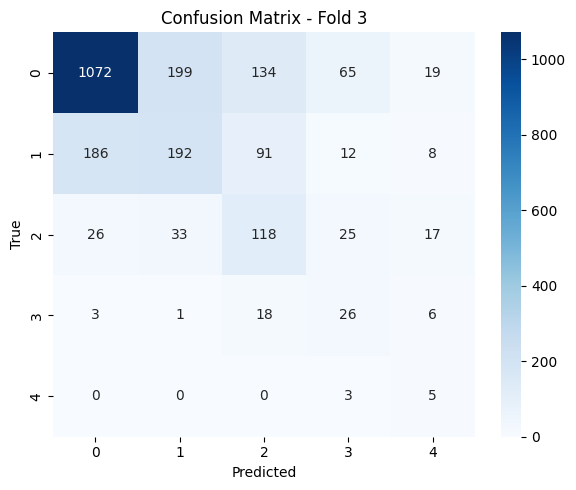

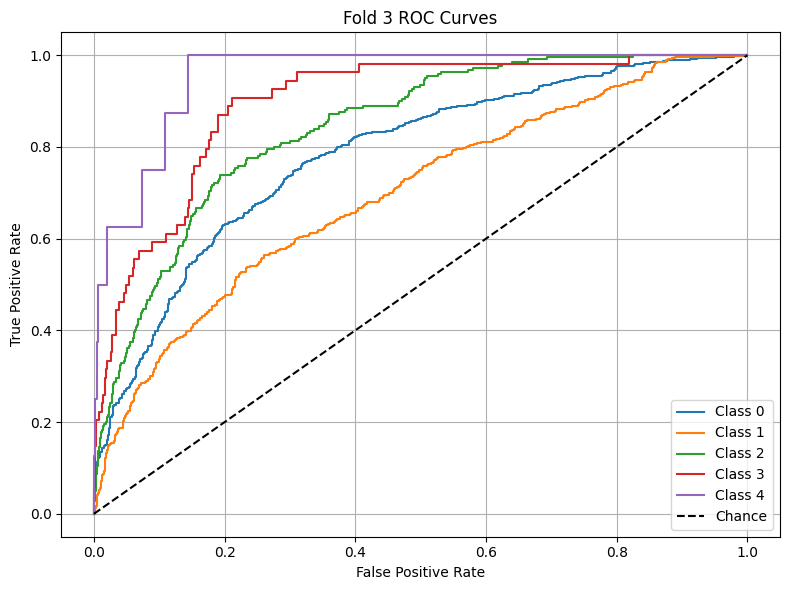


Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_accuracy = 0.62948


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


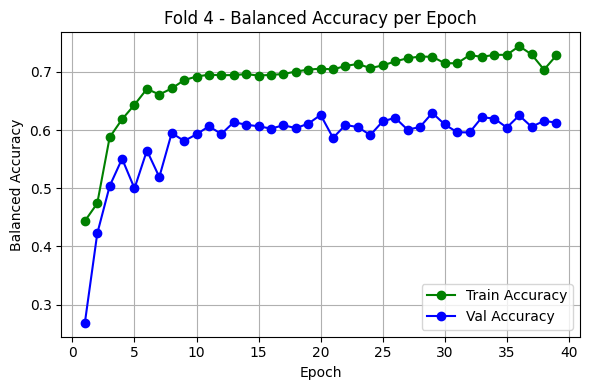


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.70      0.76      1489
           1       0.44      0.48      0.46       489
           2       0.37      0.52      0.43       219
           3       0.25      0.65      0.36        54
           4       0.09      0.50      0.15         8

    accuracy                           0.63      2259
   macro avg       0.40      0.57      0.43      2259
weighted avg       0.69      0.63      0.65      2259



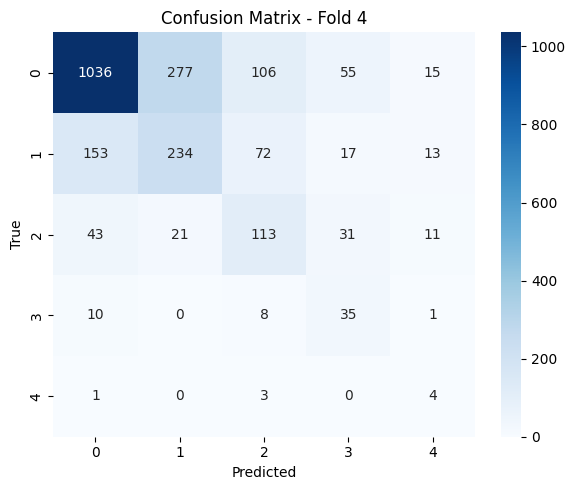

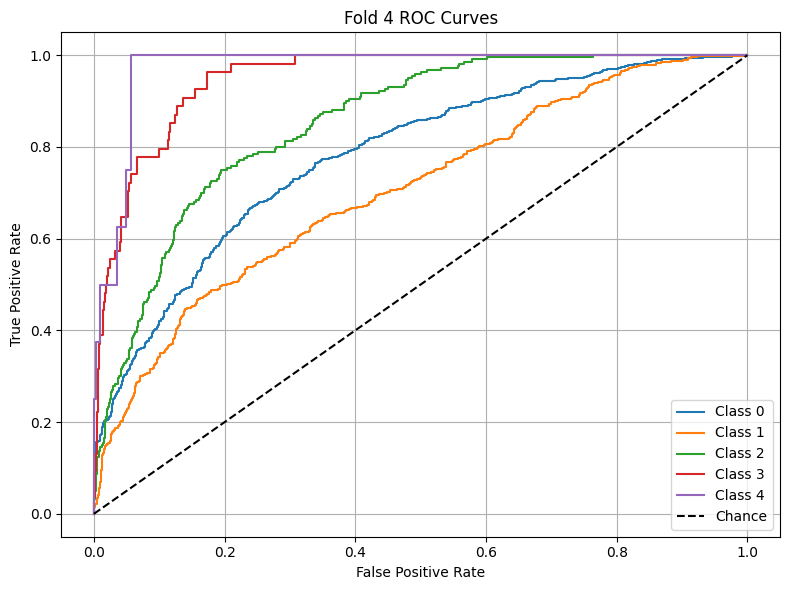


Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_accuracy = 0.61797


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


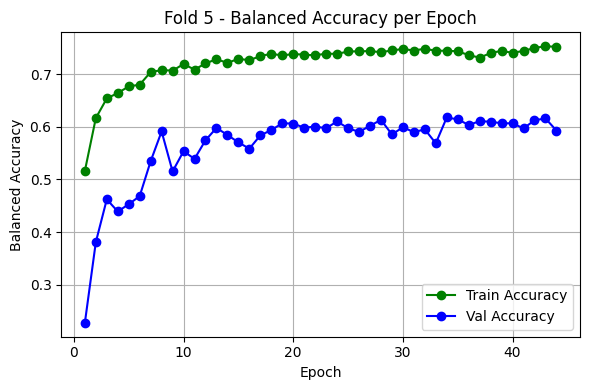


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.77      1490
           1       0.44      0.44      0.44       488
           2       0.33      0.51      0.40       219
           3       0.16      0.31      0.21        54
           4       0.06      0.50      0.10         8

    accuracy                           0.62      2259
   macro avg       0.36      0.49      0.38      2259
weighted avg       0.68      0.62      0.64      2259



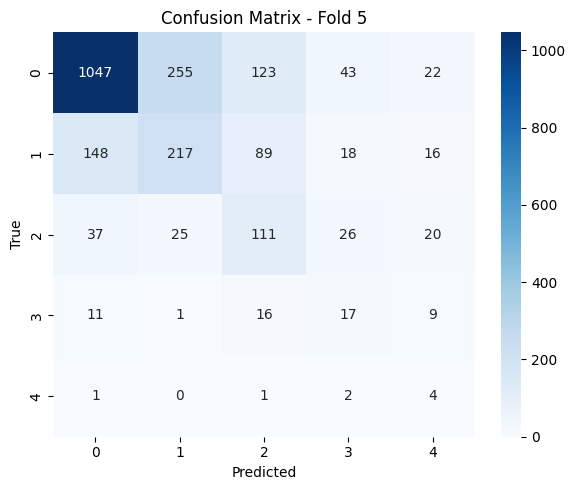

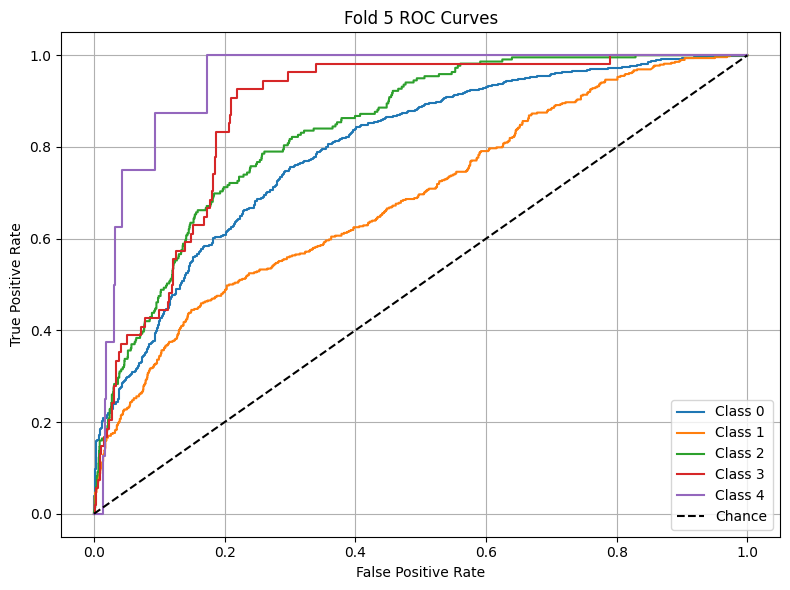


Average Accuracy: 0.6241
Average F1 Macro: 0.4095
Average AUC: 0.8361

Feature Importances:
video                           0.179881
encoded_field_sum               0.088170
combined_emb_4                  0.086087
combined_emb_15                 0.060152
assignment                      0.053019
combined_emb_5                  0.048269
combined_emb_0                  0.043204
video_count                     0.038885
user_month                      0.034898
exercise_attempts_sum_mean_1    0.033211
dtype: float64

=== Training Phase 3 ===

Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_accuracy = 0.64899


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


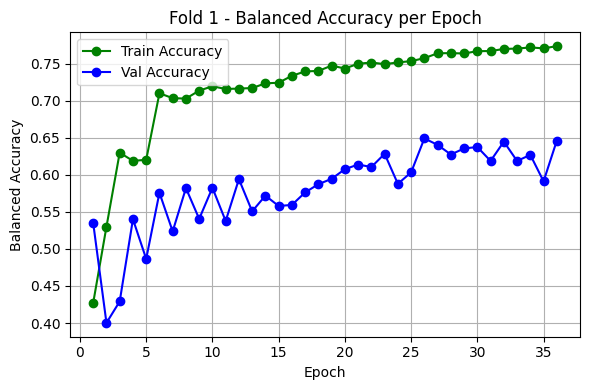


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80      1361
           1       0.53      0.37      0.44       459
           2       0.34      0.51      0.40       198
           3       0.15      0.51      0.23        49
           4       0.10      0.57      0.16         7

    accuracy                           0.65      2074
   macro avg       0.39      0.55      0.41      2074
weighted avg       0.70      0.65      0.67      2074



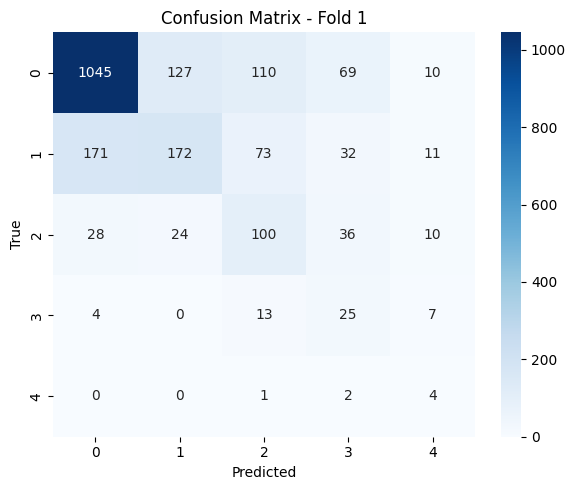

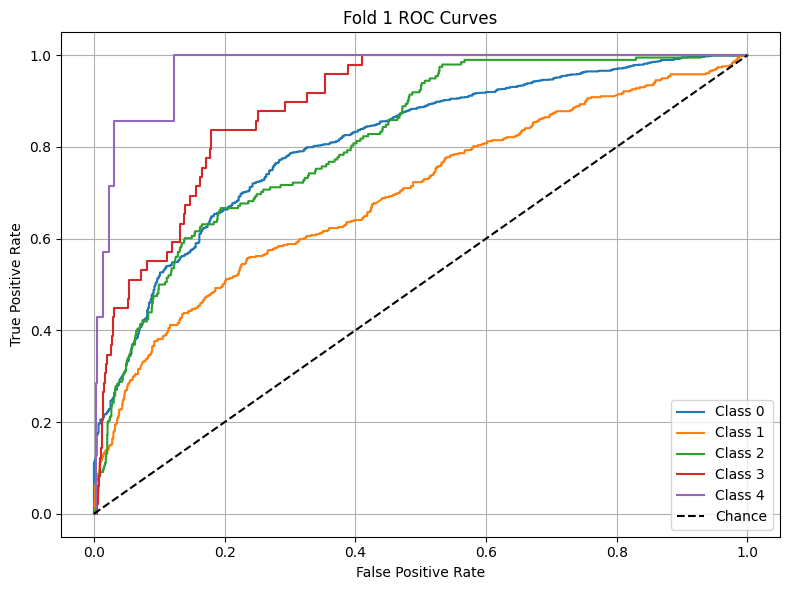


Early stopping occurred at epoch 53 with best_epoch = 43 and best_val_accuracy = 0.66683


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


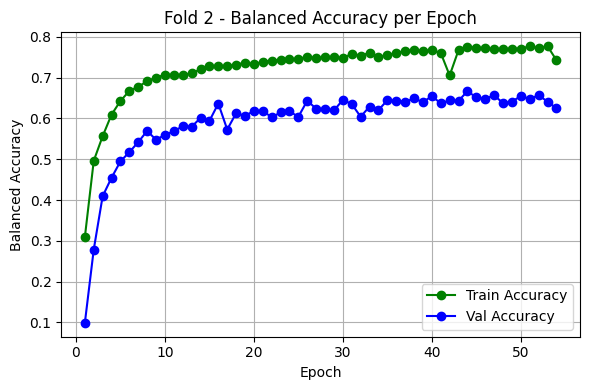


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.75      0.79      1360
           1       0.49      0.46      0.47       459
           2       0.41      0.62      0.49       198
           3       0.29      0.64      0.40        50
           4       0.07      0.29      0.11         7

    accuracy                           0.67      2074
   macro avg       0.42      0.55      0.45      2074
weighted avg       0.71      0.67      0.68      2074



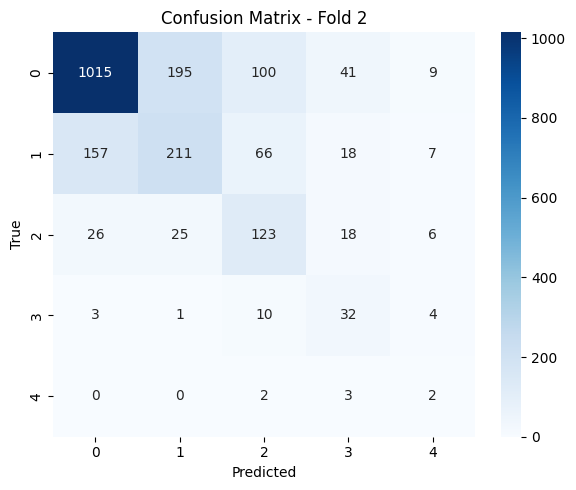

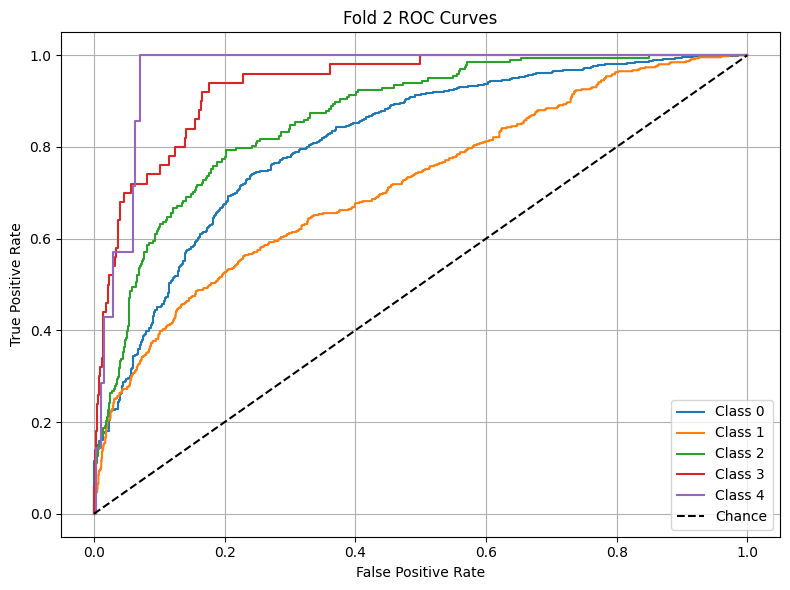


Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_accuracy = 0.62729


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


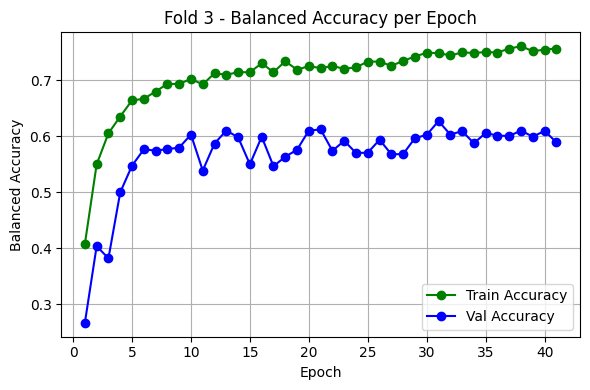


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.78      1360
           1       0.47      0.39      0.42       459
           2       0.32      0.54      0.40       198
           3       0.20      0.56      0.29        50
           4       0.10      0.57      0.17         7

    accuracy                           0.63      2074
   macro avg       0.38      0.56      0.41      2074
weighted avg       0.69      0.63      0.65      2074



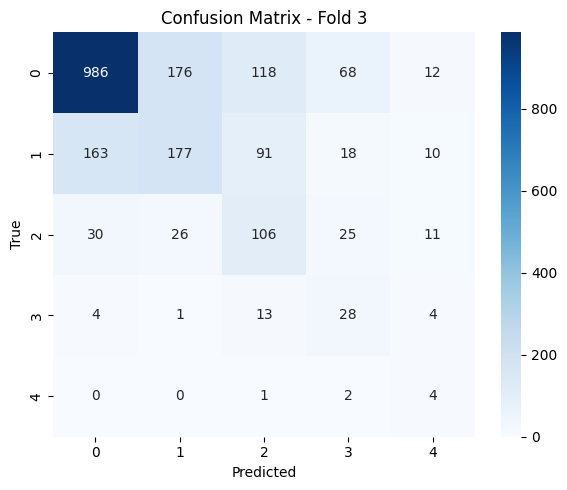

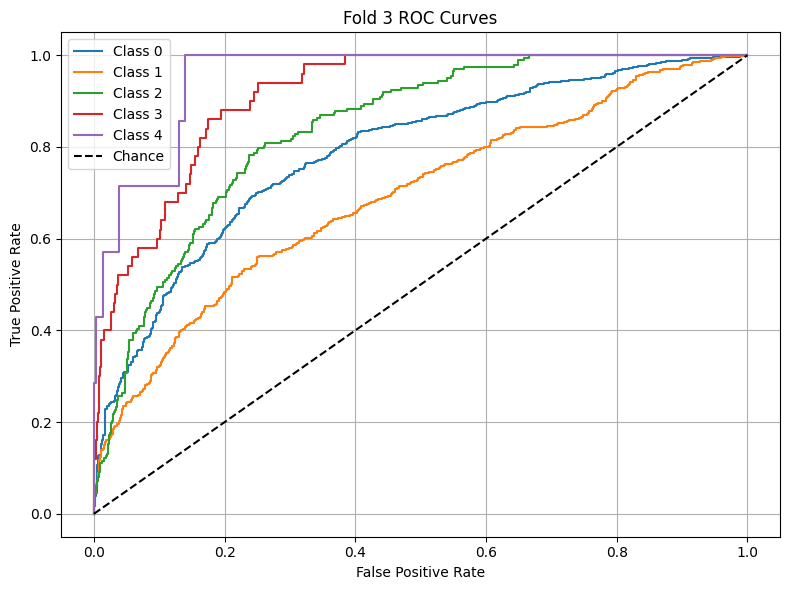


Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_accuracy = 0.59932


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


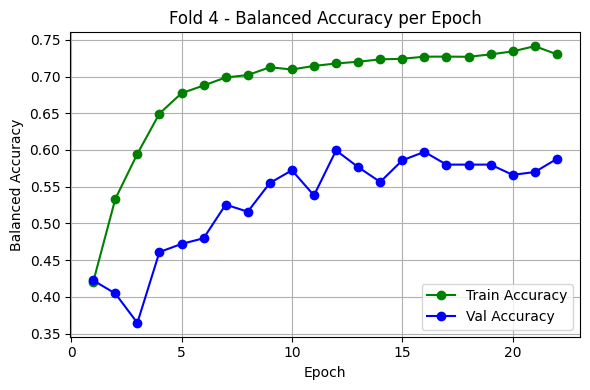


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.67      0.74      1360
           1       0.41      0.47      0.43       459
           2       0.35      0.40      0.37       198
           3       0.21      0.60      0.31        50
           4       0.05      0.43      0.08         7

    accuracy                           0.60      2074
   macro avg       0.37      0.51      0.39      2074
weighted avg       0.67      0.60      0.63      2074



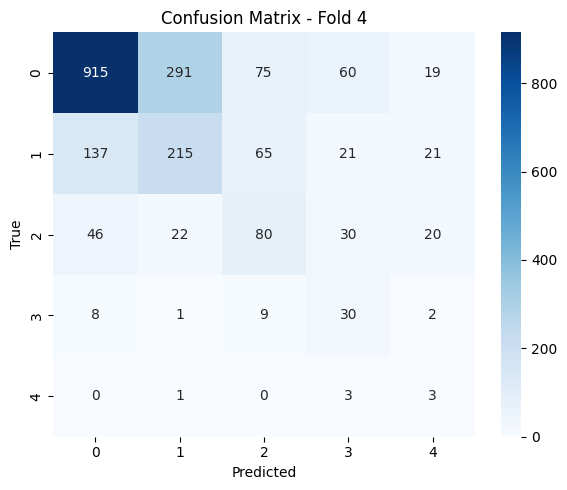

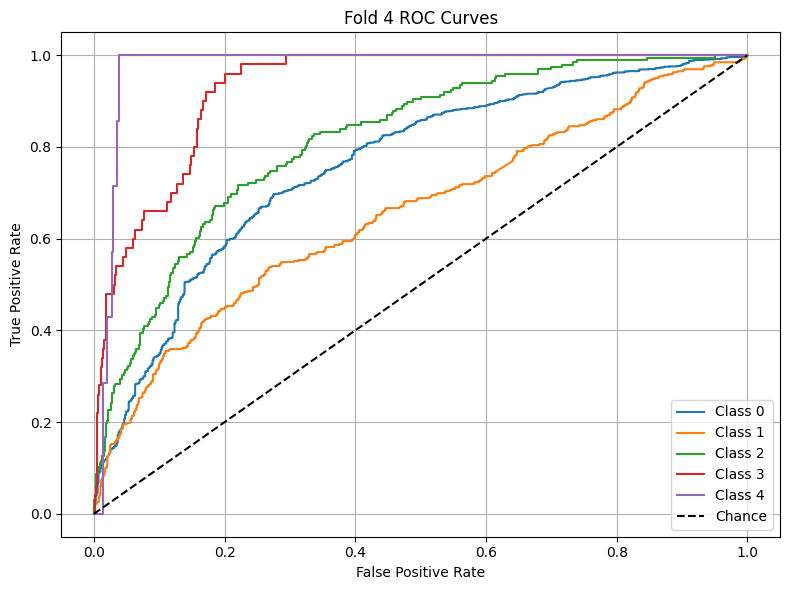


Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_accuracy = 0.61795


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


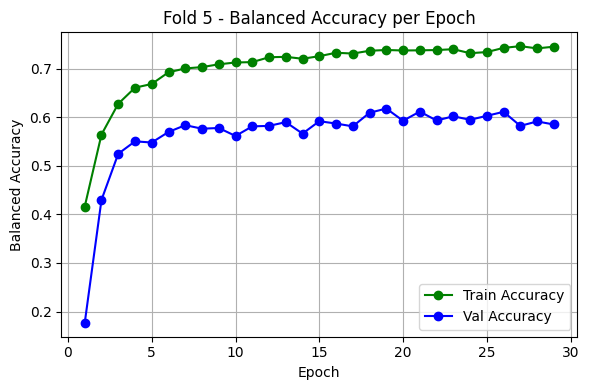


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.75      1360
           1       0.46      0.49      0.47       460
           2       0.32      0.52      0.40       197
           3       0.19      0.41      0.26        49
           4       0.05      0.29      0.09         7

    accuracy                           0.62      2073
   macro avg       0.37      0.48      0.39      2073
weighted avg       0.68      0.62      0.64      2073



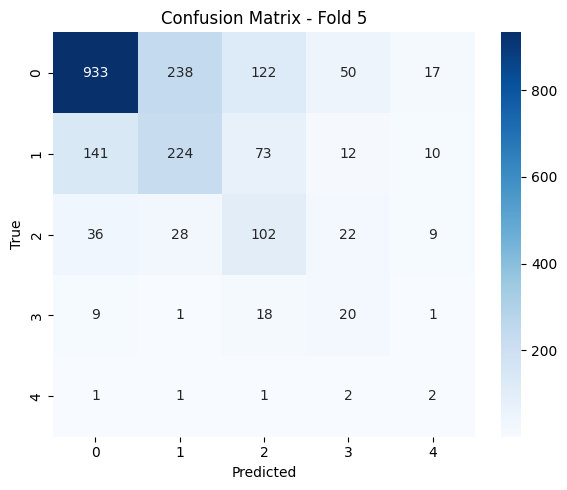

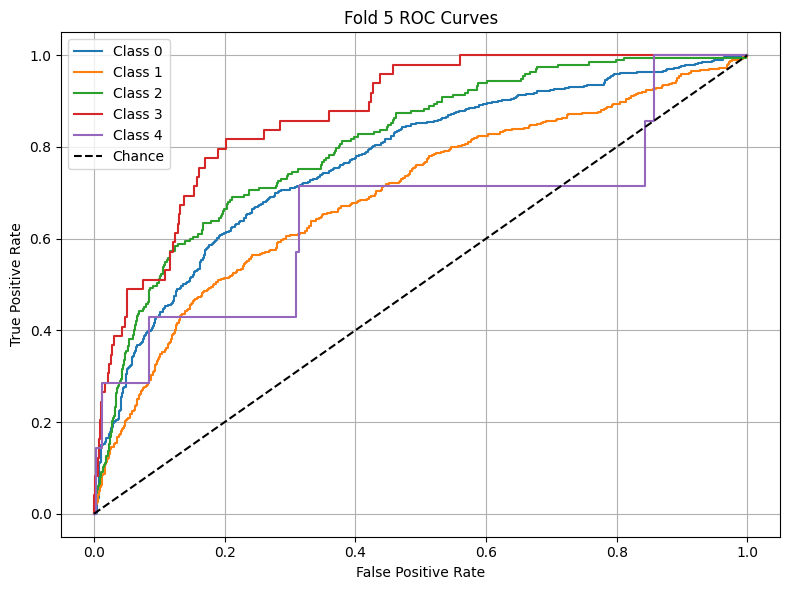


Average Accuracy: 0.6321
Average F1 Macro: 0.4112
Average AUC: 0.8238

Feature Importances:
video                          0.154139
combined_emb_9                 0.091952
entropy_time_comment_phase3    0.073577
combined_emb_11                0.068411
combined_emb_12                0.066197
certificate                    0.060998
combined_emb_3                 0.059761
user_month                     0.059495
combined_emb_10                0.055789
school                         0.044305
dtype: float64

=== Training Phase 4 ===

Early stopping occurred at epoch 51 with best_epoch = 41 and best_val_accuracy = 0.67186


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


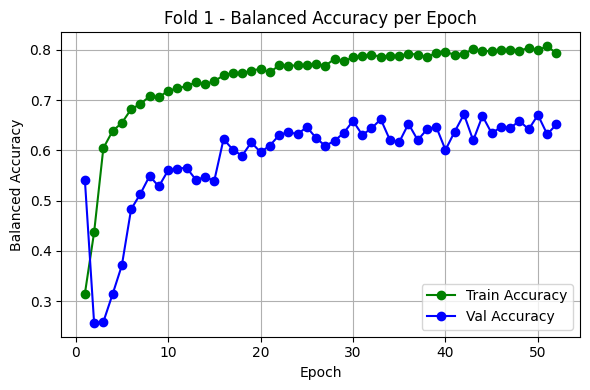


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.81      1000
           1       0.53      0.45      0.49       355
           2       0.31      0.40      0.35       139
           3       0.31      0.59      0.40        39
           4       0.18      0.67      0.29         6

    accuracy                           0.67      1539
   macro avg       0.43      0.58      0.47      1539
weighted avg       0.69      0.67      0.68      1539



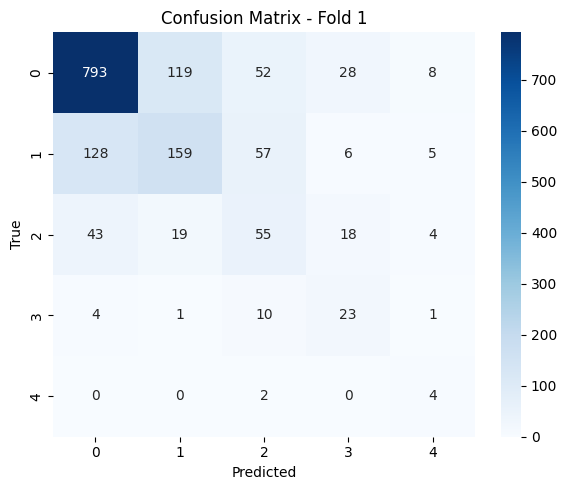

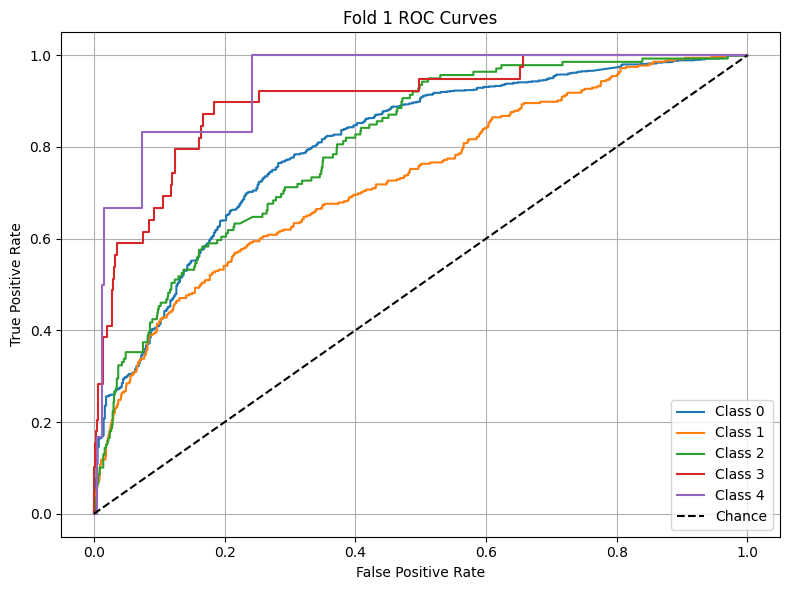


Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_accuracy = 0.66082


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


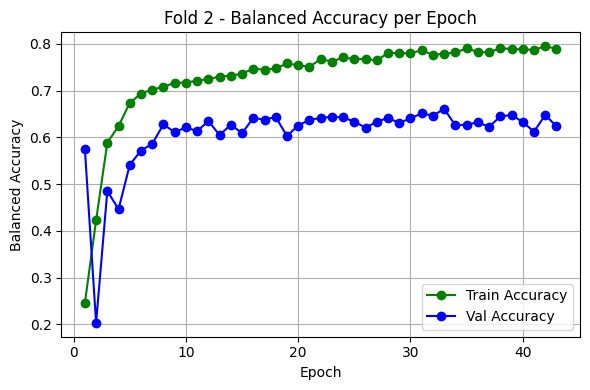


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      1000
           1       0.49      0.42      0.45       355
           2       0.49      0.50      0.49       139
           3       0.23      0.65      0.34        40
           4       0.04      0.20      0.06         5

    accuracy                           0.66      1539
   macro avg       0.41      0.51      0.43      1539
weighted avg       0.69      0.66      0.67      1539



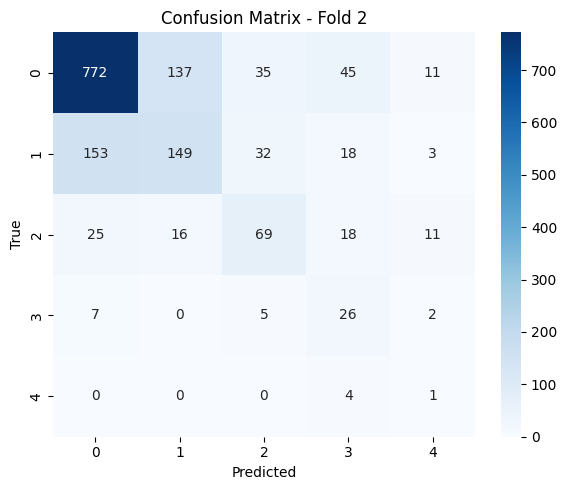

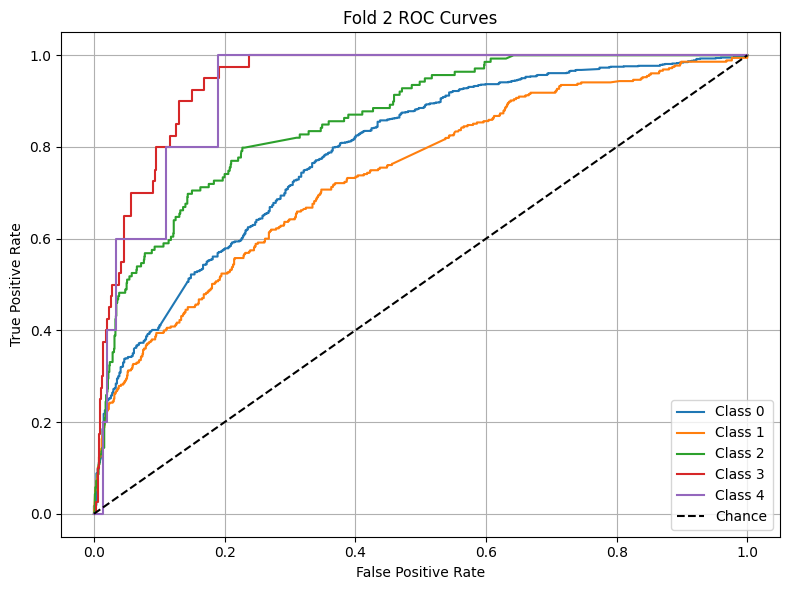


Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_accuracy = 0.60104


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


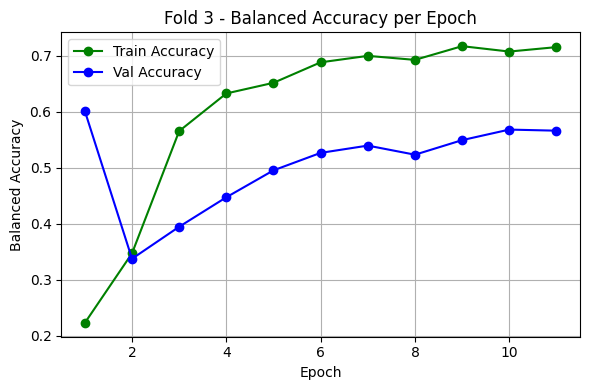

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.89      0.76       999
           1       0.22      0.10      0.14       355
           2       0.00      0.00      0.00       139
           3       0.00      0.00      0.00        40
           4       0.50      0.17      0.25         6

    accuracy                           0.60      1539
   macro avg       0.28      0.23      0.23      1539
weighted avg       0.48      0.60      0.52      1539



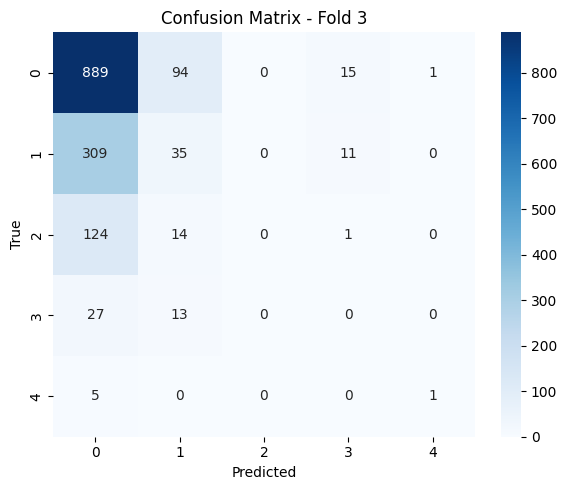

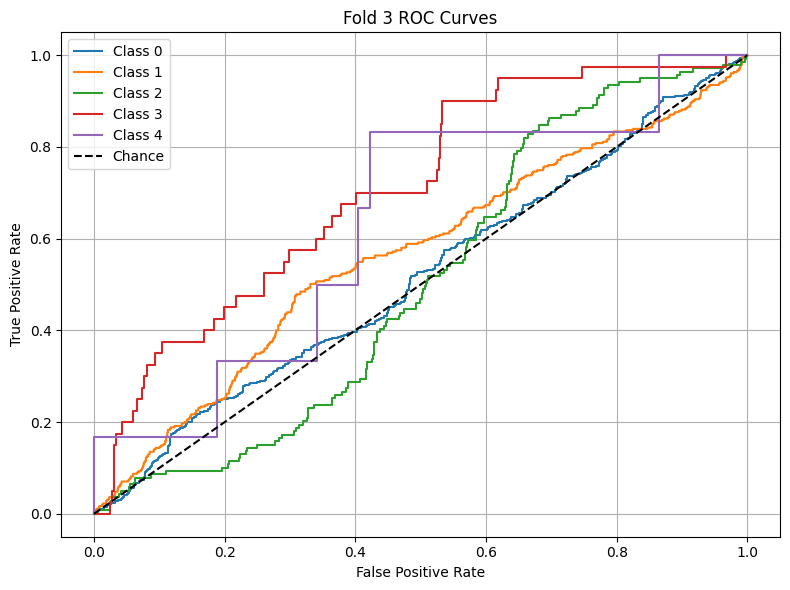


Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_accuracy = 0.66255


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


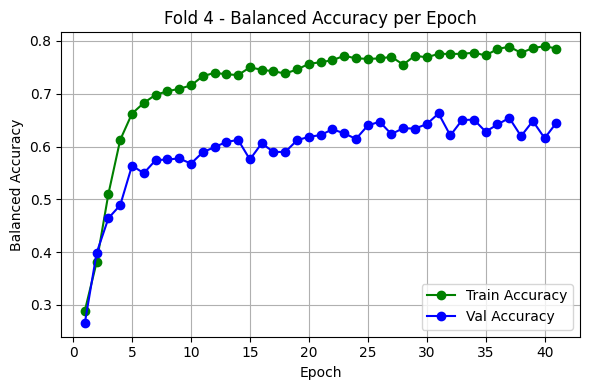


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.80       999
           1       0.48      0.41      0.44       356
           2       0.40      0.55      0.46       138
           3       0.25      0.38      0.30        39
           4       0.13      0.67      0.22         6

    accuracy                           0.66      1538
   macro avg       0.42      0.56      0.45      1538
weighted avg       0.68      0.66      0.67      1538



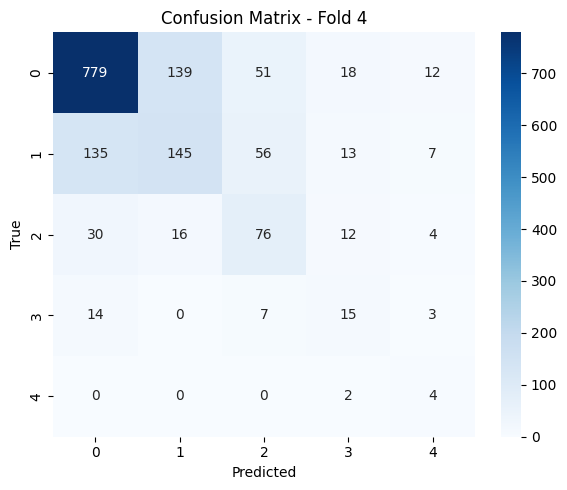

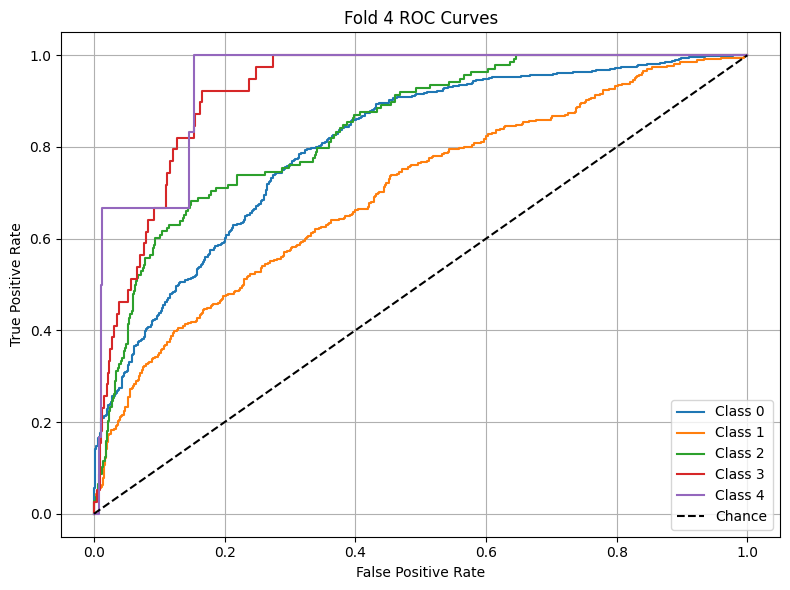


Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_accuracy = 0.64369


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


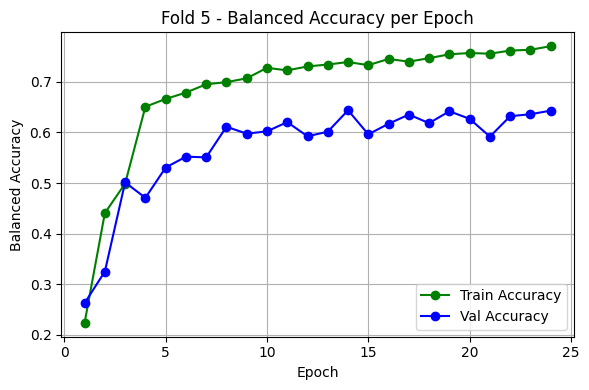


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.75      0.78       999
           1       0.50      0.44      0.47       356
           2       0.30      0.41      0.34       138
           3       0.29      0.77      0.42        39
           4       0.03      0.17      0.06         6

    accuracy                           0.64      1538
   macro avg       0.39      0.51      0.42      1538
weighted avg       0.69      0.64      0.66      1538



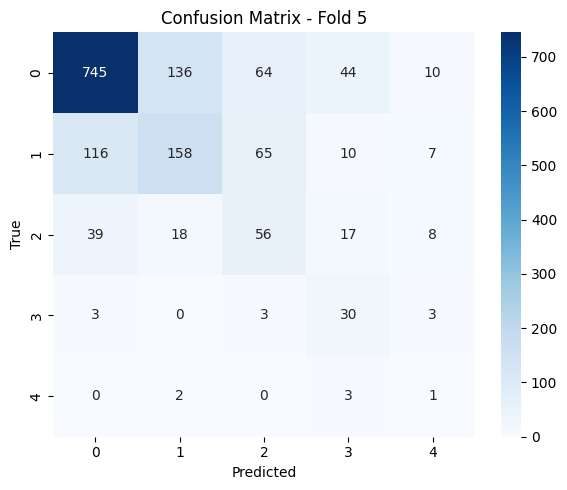

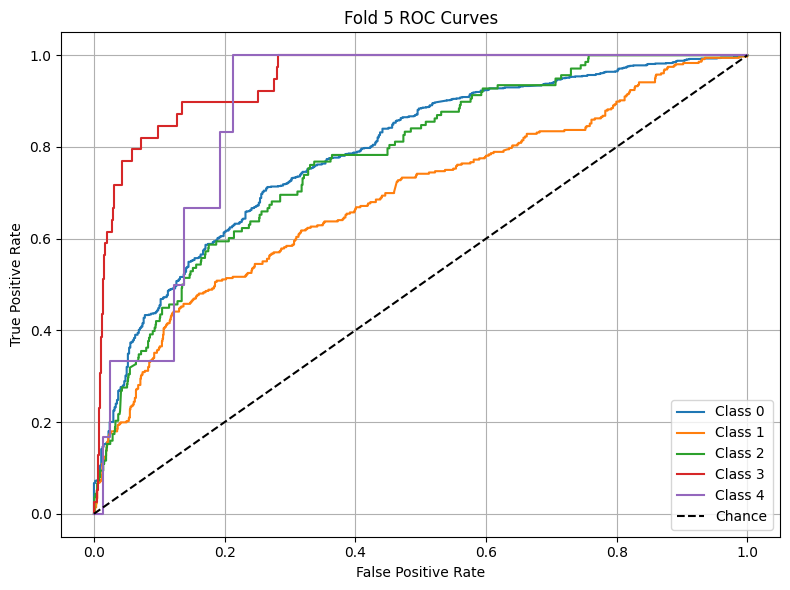


Average Accuracy: 0.6480
Average F1 Macro: 0.3967
Average AUC: 0.7860

Feature Importances:
video                          0.184750
user_month                     0.089140
total_negative4                0.064411
entropy_time_comment_phase1    0.058501
exercise_id_count_2            0.053313
combined_emb_6                 0.045930
remaining_time                 0.041303
encoded_field_sum              0.025633
exercise_id_count_3            0.025280
entropy_time_comment_phase4    0.024551
dtype: float64


In [10]:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_not_balance_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics



Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.50      0.62       568
           1       0.10      0.33      0.16        63
           2       0.09      0.28      0.14        43
           3       0.06      0.07      0.06        15
           4       0.00      0.00      0.00         9

    accuracy                           0.45       698
   macro avg       0.22      0.24      0.20       698
weighted avg       0.69      0.45      0.53       698



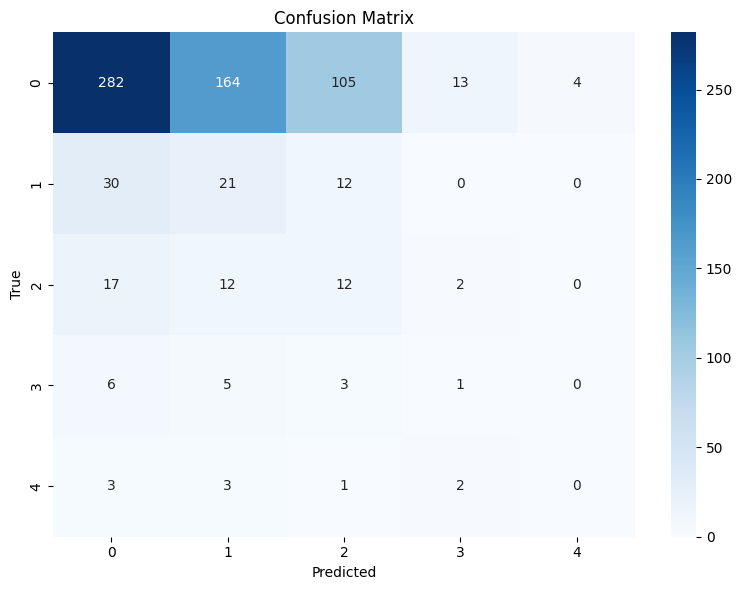


Test AUC (macro-average, OVR): 0.5468


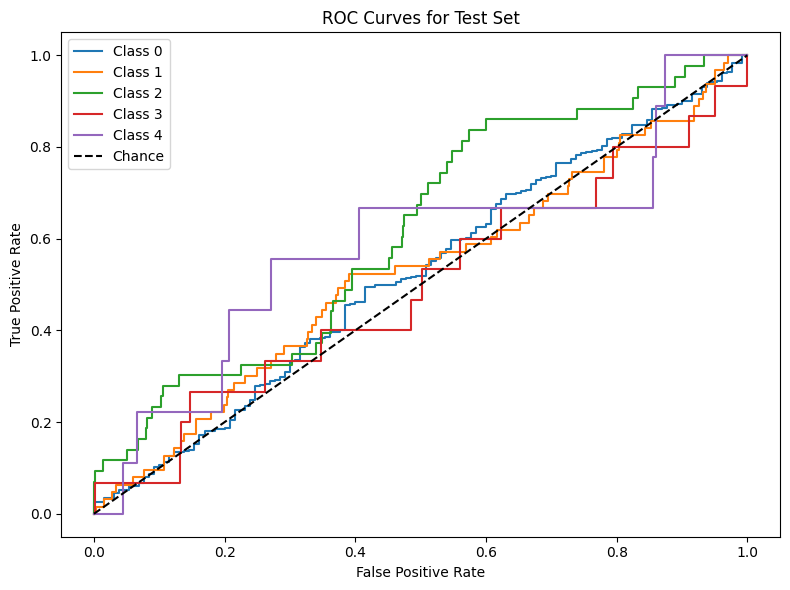


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       544
           1       0.12      0.08      0.10        59
           2       0.18      0.29      0.22        42
           3       0.20      0.14      0.17        14
           4       0.00      0.00      0.00         9

    accuracy                           0.72       668
   macro avg       0.27      0.27      0.27       668
weighted avg       0.73      0.72      0.72       668



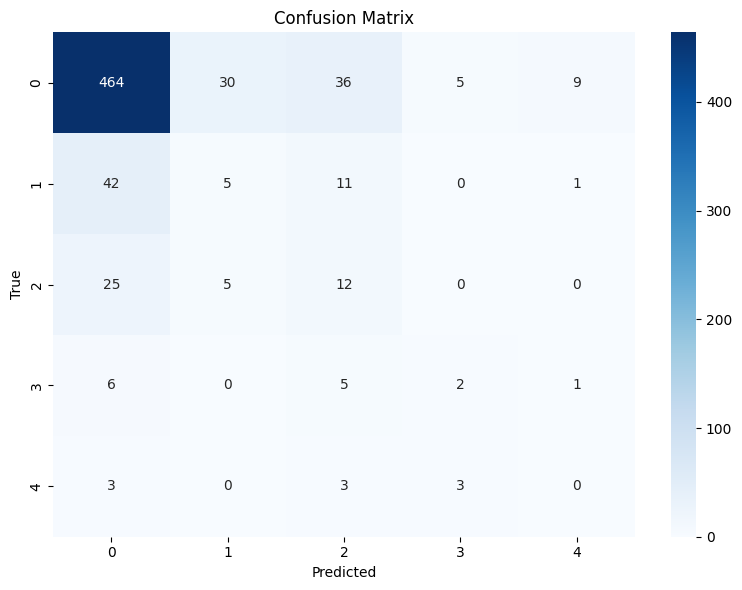


Test AUC (macro-average, OVR): 0.6615


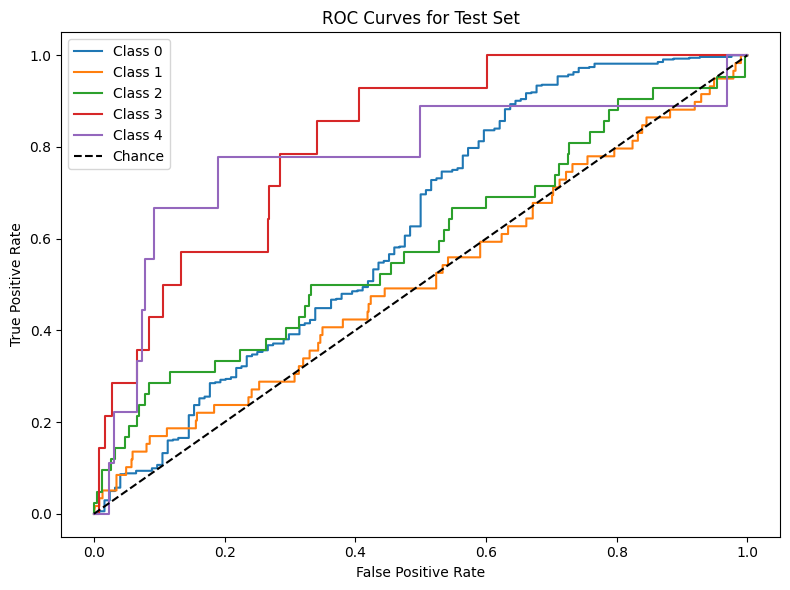


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.51      0.64       455
           1       0.10      0.19      0.14        52
           2       0.08      0.41      0.13        29
           3       0.04      0.10      0.06        10
           4       0.10      0.12      0.11         8

    accuracy                           0.46       554
   macro avg       0.24      0.27      0.21       554
weighted avg       0.72      0.46      0.55       554



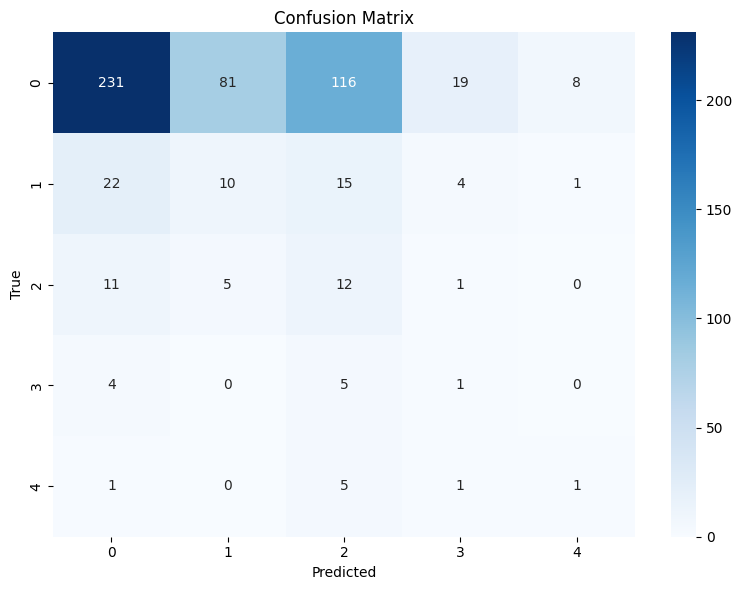


Test AUC (macro-average, OVR): 0.6138


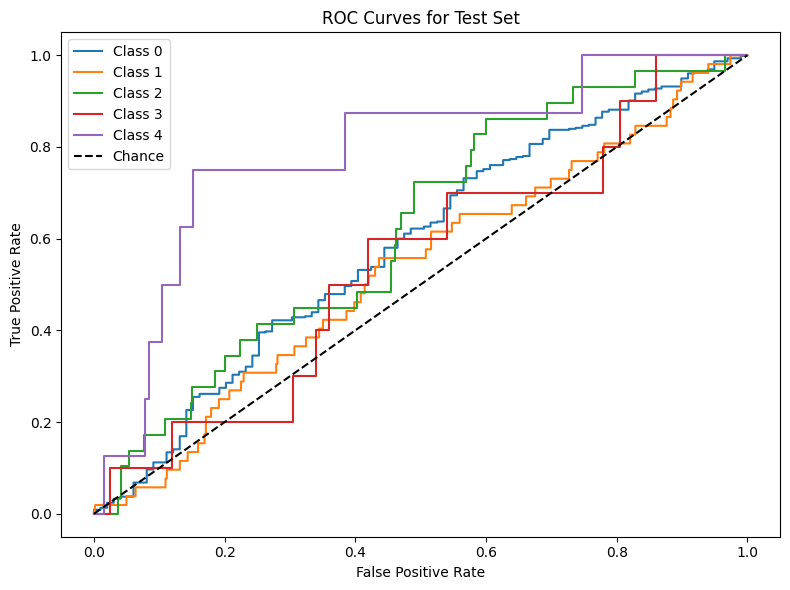


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.62      0.72       395
           1       0.11      0.28      0.15        40
           2       0.10      0.25      0.14        24
           3       0.00      0.00      0.00        10
           4       0.33      0.25      0.29         8

    accuracy                           0.56       477
   macro avg       0.28      0.28      0.26       477
weighted avg       0.72      0.56      0.62       477



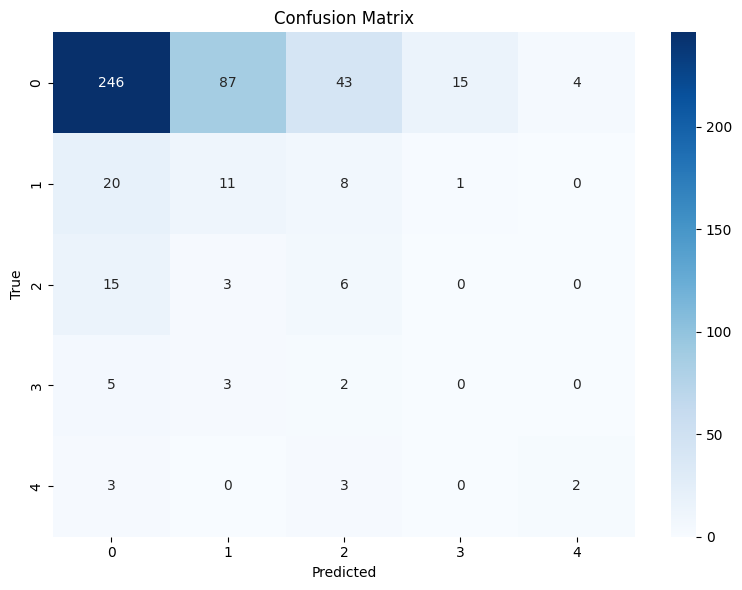


Test AUC (macro-average, OVR): 0.5749


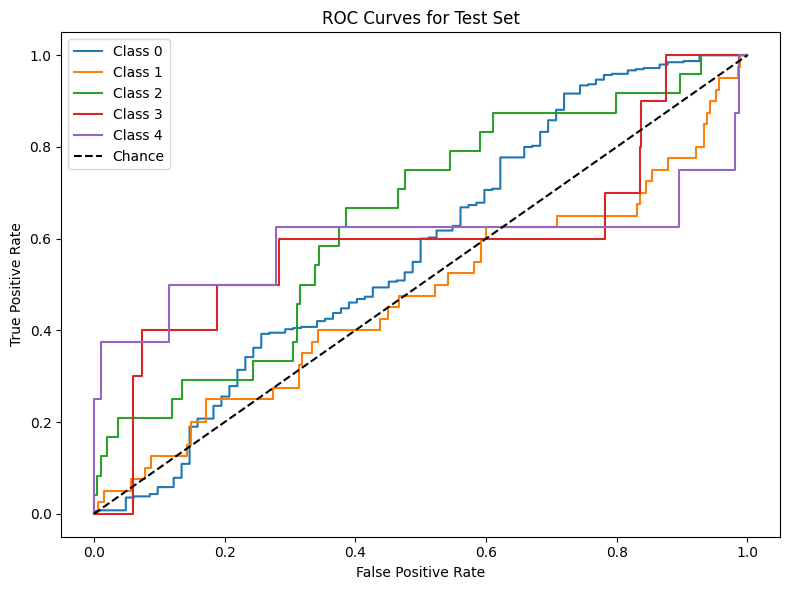

In [11]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)